In [2]:
pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.3 MB 44.8 MB/s eta 0:00:01�██████████████▎  | 3.1 MB 44.8 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/apps/ood-jupyter-py/3.8.3/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 60.9 MB 14.5 MB/s eta 0:00:014.5 MB/s eta 0:00:03��████████████████████▍          | 40.6 MB 14.5 MB/s eta 0:00:02�████████    | 53.4 MB 14.5 MB/s eta 0:00:01██████████████████████████████  | 57.1 MB 14.5 MB/s eta 0:00:01
You should consider upgrading via the '/apps/ood-jupyter-py/3.8.3/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from turtle import shape
import nibabel as nib
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
from matplotlib import cm
import pandas as pd
import re
import math
import random

# Setting paths for different folders
FLAIR_scan = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\FLAIRinT1space_withLacunes_35.tar'
T1_Lacunes_Incorrect = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\lacune_T1space.tar'
T1_Lacunes_Correct = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\lacune_T1space_JiyangCorrected20210920'
T1_scan = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\T1_withLacunes_35.tar'
T1_Soft_Tissue = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\T1softTiss_withLacunes_35.tar'
T1_Soft_Tissue_Mask = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\T1softTissMask_withLacunes_35.tar'
T1_Soft_Tissue_Binary_Mask = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\T1softTissMask_withLacunes_35_binary.tar'


In [2]:
#CSF, GM, WM
tissue_maps = '/home/z5209394/Data/tissue_prob_maps.tar/tissue_prob_maps'
CSF = []
WM = []
GM = []
for file in os.listdir(tissue_maps):
    if file.endswith(".nii.gz"):
        if file.find("CSF"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(tissue_maps, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            CSF.append(Data_list)
        if file.find("GM"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(tissue_maps, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            WM.append(Data_list)
        if file.find("WM"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(tissue_maps, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            GM.append(Data_list)

MemoryError: 

In [405]:
WM[1][1][100:110, 100:110, 50:60]

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.    

In [139]:
T1_scan_data[0][1].shape

(256, 256, 190)

In [3]:
def read_data():
    #Read all data into list
    T1_scan_data = []
    for file in os.listdir(T1_scan):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_scan, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            T1_scan_data.append(Data_list)

    #Read all FLAIR data into list
    FLAIR_scan_data = []
    for file in os.listdir(FLAIR_scan):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(FLAIR_scan, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            FLAIR_scan_data.append(Data_list)

    #Lacune Exists
    Lacune_indicator_data = []
    for file in os.listdir(T1_Lacunes_Correct):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Lacunes_Correct, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            Lacune_indicator_data.append(Data_list)

    Soft_tiss_data = []
    for file in os.listdir(T1_Soft_Tissue):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            Soft_tiss_data.append(Data_list)

    return T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data
T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data = read_data()
print("complete")

complete


In [4]:
def sample_lacunes(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_train_3D_lacune = []
    Y_train_3D_lacune = []
    Y_train_segment_3D_lacune = []
    X_train_3D_nlacune = []
    Y_train_3D_nlacune = []
    Y_train_segment_3D_nlacune = []
    
    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]
            CSF_data = CSF[brain_image][1]
            GM_data = GM[brain_image][1]
            WM_data = WM[brain_image][1]

            #Sample lacunes
            for x in range(0, data.shape[0]):
                for y in range(0, data.shape[1]):
                    for z in range(0, data.shape[2]):
                        #filter for soft tissue
                        if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165):
                            next
                        else:
                    
                            if brain_image <= 24:
                                if (Lacune_data[x,y,z] == 1) & (sum(sum(sum(Lacune_data[x-1:x+1, y-1:y+1, z-1:z+1]))) >= 4):
                                    
                                    brain_values = []
                                    brain_values_nlacune = []
                                    brain_values_rot90x = []
                                    brain_values_rot90y = []
                                    brain_values_rot90z = []
                                    brain_values_rot180x = []
                                    brain_values_rot180y = []
                                    brain_values_rot180z = []
                                    brain_values_rot270x = []
                                    brain_values_rot270y = []
                                    brain_values_rot270z = []

                                    brain_values.append(file_id)
                                    brain_values_nlacune.append(file_id)
                                    brain_values_rot90x.append(file_id)
                                    brain_values_rot90y.append(file_id)
                                    brain_values_rot90z.append(file_id)
                                    brain_values_rot180x.append(file_id)
                                    brain_values_rot180y.append(file_id)
                                    brain_values_rot180z.append(file_id)
                                    brain_values_rot270x.append(file_id)
                                    brain_values_rot270y.append(file_id)
                                    brain_values_rot270z.append(file_id)

                                    brain_values.append(x)
                                    brain_values_nlacune.append(256-x)
                                    brain_values_rot90x.append(x)
                                    brain_values_rot90y.append(x)
                                    brain_values_rot90z.append(x)
                                    brain_values_rot180x.append(x)
                                    brain_values_rot180y.append(x)
                                    brain_values_rot180z.append(x)
                                    brain_values_rot270x.append(x)
                                    brain_values_rot270y.append(x)
                                    brain_values_rot270z.append(x)

                                    brain_values.append(y)
                                    brain_values_nlacune.append(y)
                                    brain_values_rot90x.append(y)
                                    brain_values_rot90y.append(y)
                                    brain_values_rot90z.append(y)
                                    brain_values_rot180x.append(y)
                                    brain_values_rot180y.append(y)
                                    brain_values_rot180z.append(y)
                                    brain_values_rot270x.append(y)
                                    brain_values_rot270y.append(y)
                                    brain_values_rot270z.append(y)

                                    brain_values.append(z)
                                    brain_values_nlacune.append(z)
                                    brain_values_rot90x.append(z)
                                    brain_values_rot90y.append(z)
                                    brain_values_rot90z.append(z)
                                    brain_values_rot180x.append(z)
                                    brain_values_rot180y.append(z)
                                    brain_values_rot180z.append(z)
                                    brain_values_rot270x.append(z)
                                    brain_values_rot270y.append(z)
                                    brain_values_rot270z.append(z)

                                    patch_3D_T1 = T1_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_T1_nlacune = T1_data_scans[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_T1)
                                    brain_values_nlacune.append(patch_3D_T1_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_T1, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_T1, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_T1, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_T1, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_T1, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_T1, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_T1, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_T1, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_T1, k=3, axes=(0,2)))


                                    patch_3D_FLAIR = FLAIR_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_FLAIR_nlacune = FLAIR_data_scans[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_FLAIR)
                                    brain_values_nlacune.append(patch_3D_FLAIR_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_FLAIR, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_FLAIR, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_FLAIR, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_FLAIR, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_FLAIR, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_FLAIR, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_FLAIR, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_FLAIR, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_FLAIR, k=3, axes=(0,2)))

                                    patch_3D_softtiss_binary = data[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_softtiss_binary_nlacune = data[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_softtiss_binary)
                                    brain_values_nlacune.append(patch_3D_softtiss_binary_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_softtiss_binary, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_softtiss_binary, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_softtiss_binary, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_softtiss_binary, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_softtiss_binary, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_softtiss_binary, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_softtiss_binary, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_softtiss_binary, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_softtiss_binary, k=3, axes=(0,2)))

                                    patch_3D_softtiss = SoftTiss[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_softtiss_nlacune = SoftTiss[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_softtiss)
                                    brain_values_nlacune.append(patch_3D_softtiss_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_softtiss, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_softtiss, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_softtiss, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_softtiss, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_softtiss, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_softtiss, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_softtiss, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_softtiss, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_softtiss, k=3, axes=(0,2)))
                                    
                                    patch_3D_CSF = CSF_data[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_CSF_nlacune = CSF_data[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_CSF)
                                    brain_values_nlacune.append(patch_3D_CSF_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_CSF, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_CSF, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_CSF, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_CSF, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_CSF, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_CSF, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_CSF, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_CSF, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_CSF, k=3, axes=(0,2)))
                                    
                                    patch_3D_WM = WM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_WM_nlacune = WM_data[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_WM)
                                    brain_values_nlacune.append(patch_3D_WM_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_WM, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_WM, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_WM, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_WM, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_WM, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_WM, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_WM, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_WM, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_WM, k=3, axes=(0,2)))
                                    
                                    patch_3D_GM = GM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_GM_nlacune = GM_data[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_GM)
                                    brain_values_nlacune.append(patch_3D_GM_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_GM, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_GM, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_GM, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_GM, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_GM, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_GM, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_GM, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_GM, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_GM, k=3, axes=(0,2)))

                                    #brain_rotation
                                    lacune_binary = Lacune_data[x-10:x+10, y-10:y+10, z-10:z+10] 
                                    lacune_binary_nlacune = Lacune_data[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    lacune_binary_rot90x = np.rot90(lacune_binary, k=1, axes=(0,1))
                                    lacune_binary_rot90y = np.rot90(lacune_binary, k=1, axes=(1,2))
                                    lacune_binary_rot90z = np.rot90(lacune_binary, k=1, axes=(0,2))
                                    lacune_binary_rot180x = np.rot90(lacune_binary, k=2, axes=(0,1))
                                    lacune_binary_rot180y = np.rot90(lacune_binary, k=2, axes=(1,2))
                                    lacune_binary_rot180z = np.rot90(lacune_binary, k=2, axes=(0,2))
                                    lacune_binary_rot270x = np.rot90(lacune_binary, k=3, axes=(0,1))
                                    lacune_binary_rot270y = np.rot90(lacune_binary, k=3, axes=(1,2))
                                    lacune_binary_rot270z = np.rot90(lacune_binary, k=3, axes=(0,2))

                                    X_train_3D_lacune.append(brain_values)
                                    X_train_3D_nlacune.append(brain_values_nlacune)
                                    X_train_3D_lacune.append(brain_values_rot90x)
                                    X_train_3D_lacune.append(brain_values_rot90y)
                                    X_train_3D_lacune.append(brain_values_rot90z)
                                    X_train_3D_lacune.append(brain_values_rot180x)
                                    X_train_3D_lacune.append(brain_values_rot180y)
                                    X_train_3D_lacune.append(brain_values_rot180z)
                                    X_train_3D_lacune.append(brain_values_rot270x)
                                    X_train_3D_lacune.append(brain_values_rot270y)
                                    X_train_3D_lacune.append(brain_values_rot270z)
                                    
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_nlacune.append(0)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    
                                    Y_train_segment_3D_lacune.append(lacune_binary)
                                    Y_train_segment_3D_nlacune.append(lacune_binary_nlacune)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot90x)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot90y)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot90z)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot180x)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot180y)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot180z)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot270x)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot270y)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot270z)
                                    
                                    print("appended a sample")
                            
            brain_image += 1
            print(brain_image)
    return X_train_3D_lacune, Y_train_3D_lacune, Y_train_segment_3D_lacune, X_train_3D_nlacune, Y_train_3D_nlacune, Y_train_segment_3D_nlacune
X_train_3D_lacune, Y_train_3D_lacune, Y_train_segment_3D_lacune, X_train_3D_nlacune, Y_train_3D_nlacune, Y_train_segment_3D_nlacune = sample_lacunes(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a

appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a

appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
12
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
13
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appe

appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a sample
appended a

In [5]:
def non_lacune_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_train_3D_nlacune_func2 = []
    Y_train_3D_nlacune_func2 = []
    Y_train_segment_3D_nlacune_func2 = []

    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]
            CSF_data = CSF[brain_image][1]
            GM_data = GM[brain_image][1]
            WM_data = WM[brain_image][1]
            
            #Sample lacunes
            sampled_list_x = np.random.choice(data.shape[0], 3000)
            sampled_list_y = np.random.choice(data.shape[1], 3000)
            sampled_list_z = np.random.choice(data.shape[2], 3000)
            for x,y,z in set(list(zip(sampled_list_x, sampled_list_y,sampled_list_z))):
                        #filter for soft tissue
                        if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165):
                            next
                        else:
                            brain_values = []
                            brain_values.append(file_id)
                            brain_values.append(x)
                            brain_values.append(y)
                            brain_values.append(z)

                            patch_3D_T1 = T1_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_T1)

                            patch_3D_FLAIR = FLAIR_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_FLAIR)

                            patch_3D_softtiss_binary = data[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_softtiss_binary)

                            patch_3D_softtiss = SoftTiss[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_softtiss)
                            
                            patch_3D_CSF = CSF_data[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_CSF)

                            patch_3D_WM = WM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_WM)

                            patch_3D_GM = GM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                            brain_values.append(patch_3D_GM)

                            lacune_binary = Lacune_data[x-10:x+10, y-10:y+10, z-10:z+10]

                            if brain_image <= 24:
                                # No lacune exists in the 3D patch, add to train set
                                if any(1 in sublist for sublist in lacune_binary):
                                    next
                                else:
                                    X_train_3D_nlacune_func2.append(brain_values)
                                    Y_train_3D_nlacune_func2.append(0)
                                    Y_train_segment_3D_nlacune_func2.append(lacune_binary)
                                    
            brain_image += 1
            print(brain_image)

    return X_train_3D_nlacune_func2, Y_train_3D_nlacune_func2, Y_train_segment_3D_nlacune_func2
X_train_3D_nlacune_func2, Y_train_3D_nlacune_func2, Y_train_segment_3D_nlacune_func2 = non_lacune_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [33]:
def test_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_test_3D_nlacune = []
    Y_test_3D_nlacune = []
    Y_test_segment_3D_nlacune = []
    X_test_3D_lacune = []
    Y_test_3D_lacune = []
    Y_test_segment_3D_lacune = []
    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]
            CSF_data = CSF[brain_image][1]
            GM_data = GM[brain_image][1]
            WM_data = WM[brain_image][1]
            
            #Sample lacunes
            #Sample lacunes
            sampled_list_x = np.random.choice(data.shape[0], 20000)
            sampled_list_y = np.random.choice(data.shape[1], 20000)
            sampled_list_z = np.random.choice(data.shape[2], 20000)
            for x,y,z in set(list(zip(sampled_list_x, sampled_list_y,sampled_list_z))):
                        #filter for soft tissue
                        if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165):
                            next
                        else:
                            if brain_image <= 24:
                                next
                                    
                            else:
                                brain_values = []
                                brain_values.append(file_id)
                                brain_values.append(x)
                                brain_values.append(y)
                                brain_values.append(z)

                                patch_3D_T1 = T1_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                                brain_values.append(patch_3D_T1)

                                patch_3D_FLAIR = FLAIR_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                                brain_values.append(patch_3D_FLAIR)

                                patch_3D_softtiss_binary = data[x-10:x+10, y-10:y+10, z-10:z+10]
                                brain_values.append(patch_3D_softtiss_binary)

                                patch_3D_softtiss = SoftTiss[x-10:x+10, y-10:y+10, z-10:z+10]
                                brain_values.append(patch_3D_softtiss)

                                patch_3D_CSF = CSF_data[x-10:x+10, y-10:y+10, z-10:z+10]
                                brain_values.append(patch_3D_CSF)

                                patch_3D_WM = WM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                                brain_values.append(patch_3D_WM)

                                patch_3D_GM = GM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                                brain_values.append(patch_3D_GM)

                                lacune_binary = Lacune_data[x-10:x+10, y-10:y+10, z-10:z+10]
                                if (Lacune_data[x,y,z] == 1):
                                    X_test_3D_lacune.append(brain_values)
                                    Y_test_3D_lacune.append(1)
                                    Y_test_segment_3D_lacune.append(lacune_binary)
                                else:
                                    X_test_3D_nlacune.append(brain_values)
                                    Y_test_3D_nlacune.append(0)
                                    Y_test_segment_3D_nlacune.append(lacune_binary)
            brain_image += 1
            print(brain_image)

    return X_test_3D_lacune, Y_test_3D_lacune, Y_test_segment_3D_lacune, X_test_3D_nlacune, Y_test_3D_nlacune, Y_test_segment_3D_nlacune
X_test_3D_lacune, Y_test_3D_lacune, Y_test_segment_3D_lacune, X_test_3D_nlacune, Y_test_3D_nlacune, Y_test_segment_3D_nlacune = test_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [27]:
len(X_train_3D_nlacune)

3112

In [34]:
X_train_3D_nlacune_all = np.concatenate((X_train_3D_nlacune, X_train_3D_nlacune_func2), axis=0)
Y_train_3D_nlacune_all = np.concatenate((Y_train_3D_nlacune, Y_train_3D_nlacune_func2), axis=0)
Y_train_segment_3D_nlacune_all = np.concatenate((Y_train_segment_3D_nlacune, Y_train_segment_3D_nlacune_func2), axis=0)
print(len(X_train_3D_nlacune_all))
print(len(Y_train_3D_nlacune_all))
print("done")

20965
20965
done


In [26]:
X_test_3D_nlacune.shape()

AttributeError: 'list' object has no attribute 'shape'

In [35]:
X_train = np.concatenate((X_train_3D_lacune, X_train_3D_nlacune_all), axis=0)
X_test = np.concatenate((X_test_3D_lacune, X_test_3D_nlacune), axis=0)
Y_train = np.concatenate((Y_train_3D_lacune, Y_train_3D_nlacune_all), axis=0)
Y_test = np.concatenate((Y_test_3D_lacune, Y_test_3D_nlacune), axis=0)
Y_train_segment = np.concatenate((Y_train_segment_3D_lacune, Y_train_segment_3D_nlacune_all), axis=0)
Y_test_segment = np.concatenate((Y_test_segment_3D_lacune, Y_test_segment_3D_nlacune), axis=0)
print(len(X_train_3D_nlacune_all))
print(len(X_train_3D_lacune))
print("done")

20965
17380
done


In [36]:
print(len(X_test_3D_nlacune))
print(len(X_test_3D_lacune))
print("done")

51605
1
done


In [ ]:
x,y,z = Lacune_indicator_data[0][1].nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red', s= 10)
ax.set_xlim(0,256)
ax.set_ylim(0, 256)
ax.set_zlim(0, -180)
plt.savefig("demo.png")

In [ ]:
Lacune_indicator_data[0][1]

In [ ]:
m1 = np.rot90(Lacune_indicator_data[0][1], axes=(0,1))
m2 = np.rot90(Lacune_indicator_data[0][1], axes=(1,2))
m3 = np.rot90(Lacune_indicator_data[0][1], axes=(0,2))

In [ ]:
x,y,z = m1.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red', s= 10)
ax.set_xlim(0,256)
ax.set_ylim(0, 256)
ax.set_zlim(0, -180)
plt.savefig("demo.png")

In [ ]:
x,y,z = m2.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red', s= 10)
ax.set_xlim(0,256)
ax.set_ylim(0, 256)
ax.set_zlim(0, -180)
plt.savefig("demo.png")

In [ ]:
x,y,z = m3.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red', s= 10)
ax.set_xlim(0,256)
ax.set_ylim(0, 256)
ax.set_zlim(0, -180)
plt.savefig("demo.png")

In [85]:
#Features
filterSize =(16,16)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,filterSize)

min_T1 = []
med_T1 = []
mid_T1 = []
mid_vsmall_ratio_T1 = []
mid_small_ratio_T1 = []
mid_med_ratio_T1 = []
mid_large_ratio_T1 = []
mid_vsmall_ratio_T1_inc = []
mid_small_ratio_T1_inc = []
mid_med_ratio_T1_inc = []
mid_large_ratio_T1_inc = []
mean_T1 = []
max_T1 = []
var_T1 = []
range_T1 = []
min_FLAIR = []
med_FLAIR = []
mid_FLAIR = []
mid_vsmall_ratio_FLAIR = []
mid_small_ratio_FLAIR = []
mid_med_ratio_FLAIR = []
mid_large_ratio_FLAIR = []
mid_vsmall_ratio_FLAIR_inc = []
mid_small_ratio_FLAIR_inc = []
mid_med_ratio_FLAIR_inc = []
mid_large_ratio_FLAIR_inc = []
mean_FLAIR = []
max_FLAIR = []
var_FLAIR = []
range_FLAIR = []
density_diff = []
sum_soft_tiss_binary = []
sum_percent_soft_tiss = []
min_st = []
med_st = []
mid_st = []
mid_vsmall_ratio_st = []
mid_small_ratio_st = []
mid_med_ratio_st = []
mid_large_ratio_st = []
mid_vsmall_ratio_st_inc = []
mid_small_ratio_st_inc = []
mid_med_ratio_st_inc = []
mid_large_ratio_st_inc = []
mean_st = []
max_st = []
var_st = []
range_st = []
min_stm = []
med_stm = []
mid_stm = []
mid_vsmall_ratio_stm = []
mid_small_ratio_stm = []
mid_med_ratio_stm = []
mid_large_ratio_stm = []
mid_vsmall_ratio_stm_inc = []
mid_small_ratio_stm_inc = []
mid_med_ratio_stm_inc = []
mid_large_ratio_stm_inc = []
mean_stm = []
max_stm = []
var_stm = []
range_stm = []
min_th_T1 = []
med_th_T1 = []
mid_th_T1 = []
mid_vsmall_ratio_th_T1 = []
mid_small_ratio_th_T1 = []
mid_med_ratio_th_T1 = []
mid_large_ratio_th_T1 = []
mid_vsmall_ratio_th_T1_inc = []
mid_small_ratio_th_T1_inc = []
mid_med_ratio_th_T1_inc = []
mid_large_ratio_th_T1_inc = []
mean_th_T1 = []
max_th_T1 = []
var_th_T1 = []
range_th_T1 = []
min_th_FLAIR = []
med_th_FLAIR = []
mid_th_FLAIR = []
mid_vsmall_ratio_th_FLAIR = []
mid_small_ratio_th_FLAIR = []
mid_med_ratio_th_FLAIR = []
mid_large_ratio_th_FLAIR = []
mid_vsmall_ratio_th_FLAIR_inc = []
mid_small_ratio_th_FLAIR_inc = []
mid_med_ratio_th_FLAIR_inc = []
mid_large_ratio_th_FLAIR_inc = []
mean_th_FLAIR = []
max_th_FLAIR = []
var_th_FLAIR = []
range_th_FLAIR = []
min_th_st = []
med_th_st = []
mid_th_st = []
mid_vsmall_ratio_th_st = []
mid_small_ratio_th_st = []
mid_med_ratio_th_st = []
mid_large_ratio_th_st = []
mid_vsmall_ratio_th_st_inc = []
mid_small_ratio_th_st_inc = []
mid_med_ratio_th_st_inc = []
mid_large_ratio_th_st_inc = []
mean_th_st = []
max_th_st = []
var_th_st = []
range_th_st = []
min_bh_T1 = []
med_bh_T1 = []
mid_bh_T1 = []
mid_vsmall_ratio_bh_T1 = []
mid_small_ratio_bh_T1 = []
mid_med_ratio_bh_T1 = []
mid_large_ratio_bh_T1 = []
mid_vsmall_ratio_bh_T1_inc = []
mid_small_ratio_bh_T1_inc = []
mid_med_ratio_bh_T1_inc = []
mid_large_ratio_bh_T1_inc = []
mean_bh_T1 = []
max_bh_T1 = []
var_bh_T1 = []
range_bh_T1 = []
min_bh_FLAIR = []
med_bh_FLAIR = []
mid_bh_FLAIR = []
mid_vsmall_ratio_bh_FLAIR = []
mid_small_ratio_bh_FLAIR = []
mid_med_ratio_bh_FLAIR = []
mid_large_ratio_bh_FLAIR = []
mid_vsmall_ratio_bh_FLAIR_inc = []
mid_small_ratio_bh_FLAIR_inc = []
mid_med_ratio_bh_FLAIR_inc = []
mid_large_ratio_bh_FLAIR_inc = []
mean_bh_FLAIR = []
max_bh_FLAIR = []
var_bh_FLAIR = []
range_bh_FLAIR = []
min_bh_st = []
med_bh_st = []
mid_bh_st = []
mid_vsmall_ratio_bh_st = []
mid_small_ratio_bh_st = []
mid_med_ratio_bh_st = []
mid_large_ratio_bh_st = []
mid_vsmall_ratio_bh_st_inc = []
mid_small_ratio_bh_st_inc = []
mid_med_ratio_bh_st_inc = []
mid_large_ratio_bh_st_inc = []
mean_bh_st = []
max_bh_st = []
var_bh_st = []
range_bh_st = []
x = []
y = []
z = []
len_closed_contours = []
len_closed_circular_contours = []
len_other_structures = []
CSF_feat = []
GM_feat = []
WM_feat = []


for index in range(len(X_train)):
    tophat_img_T1 = cv2.morphologyEx(X_train[index][4], cv2.MORPH_TOPHAT,kernel)
    tophat_img_FLAIR = cv2.morphologyEx(X_train[index][5], cv2.MORPH_TOPHAT,kernel)
    tophat_img_st = cv2.morphologyEx(X_train[index][7], cv2.MORPH_TOPHAT,kernel)
    blackhat_img_T1 = cv2.morphologyEx(X_train[index][4], cv2.MORPH_BLACKHAT,kernel)
    blackhat_img_FLAIR = cv2.morphologyEx(X_train[index][5], cv2.MORPH_BLACKHAT,kernel)
    blackhat_img_st = cv2.morphologyEx(X_train[index][7], cv2.MORPH_BLACKHAT,kernel)
    min_T1.append(np.min(X_train[index][4]))
    med_T1.append(np.median(X_train[index][4]))
    mid_T1.append(X_train[index][4][10,10,10])
    mid_vsmall_ratio_T1.append(np.mean(X_train[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][4][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_T1.append(np.mean(X_train[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][4][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][4][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_T1.append(np.mean(X_train[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][4][6:14, 6:14, 6:14]))) - sum(sum(sum(X_train[index][4][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_T1.append(np.mean(X_train[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][4][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][4][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_T1_inc.append(np.mean(X_train[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][4][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_T1_inc.append(np.mean(X_train[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][4][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_T1_inc.append(np.mean(X_train[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][4][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_T1_inc.append(np.mean(X_train[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][4][3:17, 3:17, 3:17]))))/2744))
    mean_T1.append(np.mean(X_train[index][4]))
    max_T1.append(np.max(X_train[index][4]))
    var_T1.append(np.var(X_train[index][4]))
    range_T1.append(np.max(X_train[index][4]) - np.min(X_train[index][4]))
    min_FLAIR.append(np.min(X_train[index][5]))
    med_FLAIR.append(np.median(X_train[index][5]))
    mid_FLAIR.append(X_train[index][5][10,10,10])
    mid_vsmall_ratio_FLAIR.append(np.mean(X_train[index][5][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][5][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][5][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_FLAIR.append(np.mean(X_train[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][5][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][5][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_FLAIR.append(np.mean(X_train[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][5][6:14, 6:14, 6:14]))) - sum(sum(sum(X_train[index][5][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_FLAIR.append(np.mean(X_train[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][5][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][5][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_FLAIR_inc.append(np.mean(X_train[index][5][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][5][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_FLAIR_inc.append(np.mean(X_train[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][5][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_FLAIR_inc.append(np.mean(X_train[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][5][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_FLAIR_inc.append(np.mean(X_train[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][5][3:17, 3:17, 3:17]))))/2744))
    mean_FLAIR.append(np.mean(X_train[index][5]))
    max_FLAIR.append(np.max(X_train[index][5]))
    var_FLAIR.append(np.var(X_train[index][5]))
    range_FLAIR.append(np.max(X_train[index][5]) - np.min(X_train[index][5]))
    density_diff.append(X_train[index][5][10,10,10] - X_train[index][4][10,10,10])
    sum_soft_tiss_binary.append(sum(sum(sum(X_train[index][6]))))
    sum_percent_soft_tiss.append(sum(sum(sum(X_train[index][7]))))
    min_st.append(np.min(X_train[index][6]))
    med_st.append(np.median(X_train[index][6]))
    mid_st.append(X_train[index][6][10,10,10])
    mid_vsmall_ratio_st.append(np.mean(X_train[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][6][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_st.append(np.mean(X_train[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][6][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_st.append(np.mean(X_train[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][6][6:14, 6:14, 6:14]))) - sum(sum(sum(X_train[index][6][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_st.append(np.mean(X_train[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][6][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][6][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_st_inc.append(np.mean(X_train[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_st_inc.append(np.mean(X_train[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][6][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_st_inc.append(np.mean(X_train[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][6][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_st_inc.append(np.mean(X_train[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][6][3:17, 3:17, 3:17]))))/2744))
    mean_st.append(np.mean(X_train[index][6]))
    max_st.append(np.max(X_train[index][6]))
    var_st.append(np.var(X_train[index][6]))
    range_st.append(np.max(X_train[index][6]) - np.min(X_train[index][6]))
    min_stm.append(np.min(X_train[index][7]))
    med_stm.append(np.median(X_train[index][7]))
    mid_stm.append(X_train[index][7][10,10,10])
    mid_vsmall_ratio_stm.append(np.mean(X_train[index][7][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][7][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][7][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_stm.append(np.mean(X_train[index][7][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][7][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][7][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_stm.append(np.mean(X_train[index][7][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][7][6:14, 6:14, 6:14]))) - sum(sum(sum(X_train[index][7][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_stm.append(np.mean(X_train[index][7][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][7][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][7][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_stm_inc.append(np.mean(X_train[index][7][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][7][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_stm_inc.append(np.mean(X_train[index][7][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][7][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_stm_inc.append(np.mean(X_train[index][7][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][7][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_stm_inc.append(np.mean(X_train[index][7][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][7][3:17, 3:17, 3:17]))))/2744))
    mean_stm.append(np.mean(X_train[index][7]))
    max_stm.append(np.max(X_train[index][7]))
    var_stm.append(np.var(X_train[index][7]))
    range_stm.append(np.max(X_train[index][7]) - np.min(X_train[index][7]))
    min_th_T1.append(np.min(tophat_img_T1))
    med_th_T1.append(np.median(tophat_img_T1))
    mid_th_T1.append(tophat_img_T1[10,10,10])
    mid_vsmall_ratio_th_T1.append(np.mean(tophat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_T1[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_T1.append(np.mean(tophat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_T1.append(np.mean(tophat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_T1.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_T1_inc.append(np.mean(tophat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_T1_inc.append(np.mean(tophat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_T1_inc.append(np.mean(tophat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_T1_inc.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1[3:17, 3:17, 3:17]))))/2744))
    mean_th_T1.append(np.mean(tophat_img_T1))
    max_th_T1.append(np.max(tophat_img_T1))
    var_th_T1.append(np.var(tophat_img_T1))
    range_th_T1.append(np.max(tophat_img_T1) - np.min(tophat_img_T1))
    min_th_FLAIR.append(np.min(tophat_img_FLAIR))
    med_th_FLAIR.append(np.median(tophat_img_FLAIR))
    mid_th_FLAIR.append(tophat_img_FLAIR[10,10,10])
    mid_vsmall_ratio_th_FLAIR.append(np.mean(tophat_img_FLAIR[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_FLAIR[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_FLAIR[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_FLAIR.append(np.mean(tophat_img_FLAIR[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_FLAIR[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_FLAIR[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_FLAIR.append(np.mean(tophat_img_FLAIR[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_FLAIR[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_FLAIR[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_FLAIR.append(np.mean(tophat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_FLAIR[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_FLAIR[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_FLAIR_inc.append(np.mean(tophat_img_FLAIR[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_FLAIR[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_FLAIR_inc.append(np.mean(tophat_img_FLAIR[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_FLAIR[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_FLAIR_inc.append(np.mean(tophat_img_FLAIR[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_FLAIR[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_FLAIR_inc.append(np.mean(tophat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_FLAIR[3:17, 3:17, 3:17]))))/2744))
    mean_th_FLAIR.append(np.mean(tophat_img_FLAIR))
    max_th_FLAIR.append(np.max(tophat_img_FLAIR))
    var_th_FLAIR.append(np.var(tophat_img_FLAIR))
    range_th_FLAIR.append(np.max(tophat_img_FLAIR) - np.min(tophat_img_FLAIR))
    min_th_st.append(np.min(tophat_img_st))
    med_th_st.append(np.median(tophat_img_st))
    mid_th_st.append(tophat_img_st[10,10,10])
    mid_vsmall_ratio_th_st.append(np.mean(tophat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_st[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_st.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_st.append(np.mean(tophat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_st.append(np.mean(tophat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_st_inc.append(np.mean(tophat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_st_inc.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_st_inc.append(np.mean(tophat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_st_inc.append(np.mean(tophat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st[3:17, 3:17, 3:17]))))/2744))
    mean_th_st.append(np.mean(tophat_img_st))
    max_th_st.append(np.max(tophat_img_st))
    var_th_st.append(np.var(tophat_img_st))
    range_th_st.append(np.max(tophat_img_st) - np.min(tophat_img_st))
    min_bh_T1.append(np.min(blackhat_img_T1))
    med_bh_T1.append(np.median(blackhat_img_T1))
    mid_bh_T1.append(blackhat_img_T1[10,10,10])
    mid_vsmall_ratio_bh_T1.append(np.mean(blackhat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_T1[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_T1[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_T1.append(np.mean(blackhat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_T1[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_T1[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_T1.append(np.mean(blackhat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_T1[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_T1[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_T1.append(np.mean(blackhat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_T1[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_T1[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_T1_inc.append(np.mean(blackhat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_T1[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_T1_inc.append(np.mean(blackhat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_T1[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_T1_inc.append(np.mean(blackhat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_T1[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_T1_inc.append(np.mean(blackhat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_T1[3:17, 3:17, 3:17]))))/2744))
    mean_bh_T1.append(np.mean(blackhat_img_T1))
    max_bh_T1.append(np.max(blackhat_img_T1))
    var_bh_T1.append(np.var(blackhat_img_T1))
    range_bh_T1.append(np.max(blackhat_img_T1) - np.min(blackhat_img_T1))
    min_bh_FLAIR.append(np.min(blackhat_img_FLAIR))
    med_bh_FLAIR.append(np.median(blackhat_img_FLAIR))
    mid_bh_FLAIR.append(blackhat_img_FLAIR[10,10,10])
    mid_vsmall_ratio_bh_FLAIR.append(np.mean(blackhat_img_FLAIR[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_FLAIR[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_FLAIR[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_FLAIR.append(np.mean(blackhat_img_FLAIR[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_FLAIR[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_FLAIR[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_FLAIR.append(np.mean(blackhat_img_FLAIR[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_FLAIR[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_FLAIR[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_FLAIR.append(np.mean(blackhat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_FLAIR[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_FLAIR[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_FLAIR_inc.append(np.mean(blackhat_img_FLAIR[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_FLAIR[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_FLAIR_inc.append(np.mean(blackhat_img_FLAIR[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_FLAIR[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_FLAIR_inc.append(np.mean(blackhat_img_FLAIR[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_FLAIR[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_FLAIR_inc.append(np.mean(blackhat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_FLAIR[3:17, 3:17, 3:17]))))/2744))
    mean_bh_FLAIR.append(np.mean(blackhat_img_FLAIR))
    max_bh_FLAIR.append(np.max(blackhat_img_FLAIR))
    var_bh_FLAIR.append(np.var(blackhat_img_FLAIR))
    range_bh_FLAIR.append(np.max(blackhat_img_FLAIR) - np.min(blackhat_img_FLAIR))
    min_bh_st.append(np.min(blackhat_img_st))
    med_bh_st.append(np.median(blackhat_img_st))
    mid_bh_st.append(blackhat_img_st[10,10,10])
    mid_vsmall_ratio_bh_st.append(np.mean(blackhat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_st[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_st.append(np.mean(blackhat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_st[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_st.append(np.mean(blackhat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_st[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_st[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_st.append(np.mean(blackhat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_st[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_st[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_st_inc.append(np.mean(blackhat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_st_inc.append(np.mean(blackhat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_st[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_st_inc.append(np.mean(blackhat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_st[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_st_inc.append(np.mean(blackhat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_st[3:17, 3:17, 3:17]))))/2744))
    mean_bh_st.append(np.mean(blackhat_img_st))
    max_bh_st.append(np.max(blackhat_img_st))
    var_bh_st.append(np.var(blackhat_img_st))
    range_bh_st.append(np.max(blackhat_img_st) - np.min(blackhat_img_st))
    x.append(X_train[index][1])
    y.append(X_train[index][2])
    z.append(X_train[index][3])
    img = X_train[index][4][:, 10, :]*255
    input_image = img.copy()
    input_image = input_image.astype('uint8')
    stacked_img = np.stack((input_image,)*3, axis=-1)
    input_image = cv2.cvtColor(stacked_img, cv2.COLOR_BGR2GRAY)
    input_image = cv2.medianBlur(input_image, 3)
    ret, thresh = cv2.threshold(input_image, 90, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    closed_contours = []
    i = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if (area > 3) & (area < 175):
            closed_contours.append(cnt)
        else:
            i+=1
    contours_cirles = []
    # check if contour is of circular shape
    for con in closed_contours:
        perimeter = cv2.arcLength(con, True)
        area = cv2.contourArea(con)
        if (perimeter == 0):
            continue
        circularity = 4*math.pi*(area/(perimeter*perimeter))
        if 0.7 < circularity < 1.2:
            contours_cirles.append(con)
    len_closed_contours.append(len(closed_contours))
    len_closed_circular_contours.append(len(contours_cirles))
    len_other_structures.append(i)
    
    #edges = canny(tophat_img)
    CSF_feat.append(np.mean(X_train[index][8]))
    GM_feat.append(np.mean(X_train[index][10]))
    WM_feat.append(np.mean(X_train[index][9]))


C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3014361375.py:212: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_st.append(np.mean(X_train[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][6][9:11, 9:11, 9:11]))))/56))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3014361375.py:216: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_st_inc.append(np.mean(X_train[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))))/64))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3014361375.py:227: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_stm.append(np.mean(X_train[index][7][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][7][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][7][9:11, 9:11, 9:11]))))/56))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3014361375.py:231: RuntimeWarning: invalid value enco

C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3014361375.py:179: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_T1.append(np.mean(X_train[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][4][9:11, 9:11, 9:11]))))/56))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3014361375.py:183: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_T1_inc.append(np.mean(X_train[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][4][8:12, 8:12, 8:12]))))/64))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3014361375.py:242: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_th_T1.append(np.mean(tophat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_T1[9:11, 9:11, 9:11]))))/56))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3014361375.py:246: RuntimeWarning: invalid value encountered in

In [82]:
#Features
min_T1_test = []
med_T1_test = []
mid_T1_test = []
mid_vsmall_ratio_T1_test = []
mid_small_ratio_T1_test = []
mid_med_ratio_T1_test = []
mid_large_ratio_T1_test = []
mid_vsmall_ratio_T1_inc_test = []
mid_small_ratio_T1_inc_test = []
mid_med_ratio_T1_inc_test = []
mid_large_ratio_T1_inc_test = []
mean_T1_test = []
max_T1_test = []
var_T1_test = []
range_T1_test = []
min_FLAIR_test = []
med_FLAIR_test = []
mid_FLAIR_test = []
mid_vsmall_ratio_FLAIR_test = []
mid_small_ratio_FLAIR_test = []
mid_med_ratio_FLAIR_test = []
mid_large_ratio_FLAIR_test = []
mid_vsmall_ratio_FLAIR_inc_test = []
mid_small_ratio_FLAIR_inc_test = []
mid_med_ratio_FLAIR_inc_test = []
mid_large_ratio_FLAIR_inc_test = []
mean_FLAIR_test = []
max_FLAIR_test = []
var_FLAIR_test = []
range_FLAIR_test = []
density_diff_test = []
sum_soft_tiss_binary_test = []
sum_percent_soft_tiss_test = []
min_st_test = []
med_st_test = []
mid_st_test = []
mid_vsmall_ratio_st_test = []
mid_small_ratio_st_test = []
mid_med_ratio_st_test = []
mid_large_ratio_st_test = []
mid_vsmall_ratio_st_inc_test = []
mid_small_ratio_st_inc_test = []
mid_med_ratio_st_inc_test = []
mid_large_ratio_st_inc_test = []
mean_st_test = []
max_st_test = []
var_st_test = []
range_st_test = []
min_stm_test = []
med_stm_test = []
mid_stm_test = []
mid_vsmall_ratio_stm_test = []
mid_small_ratio_stm_test = []
mid_med_ratio_stm_test = []
mid_large_ratio_stm_test = []
mid_vsmall_ratio_stm_inc_test = []
mid_small_ratio_stm_inc_test = []
mid_med_ratio_stm_inc_test = []
mid_large_ratio_stm_inc_test = []
mean_stm_test = []
max_stm_test = []
var_stm_test = []
range_stm_test = []
min_th_T1_test = []
med_th_T1_test = []
mid_th_T1_test = []
mid_vsmall_ratio_th_T1_test = []
mid_small_ratio_th_T1_test = []
mid_med_ratio_th_T1_test = []
mid_large_ratio_th_T1_test = []
mid_vsmall_ratio_th_T1_inc_test = []
mid_small_ratio_th_T1_inc_test = []
mid_med_ratio_th_T1_inc_test = []
mid_large_ratio_th_T1_inc_test = []
mean_th_T1_test = []
max_th_T1_test = []
var_th_T1_test = []
range_th_T1_test = []
min_th_FLAIR_test = []
med_th_FLAIR_test = []
mid_th_FLAIR_test = []
mid_vsmall_ratio_th_FLAIR_test = []
mid_small_ratio_th_FLAIR_test = []
mid_med_ratio_th_FLAIR_test = []
mid_large_ratio_th_FLAIR_test = []
mid_vsmall_ratio_th_FLAIR_inc_test = []
mid_small_ratio_th_FLAIR_inc_test = []
mid_med_ratio_th_FLAIR_inc_test = []
mid_large_ratio_th_FLAIR_inc_test = []
mean_th_FLAIR_test = []
max_th_FLAIR_test = []
var_th_FLAIR_test = []
range_th_FLAIR_test = []
min_th_st_test = []
med_th_st_test = []
mid_th_st_test = []
mid_vsmall_ratio_th_st_test = []
mid_small_ratio_th_st_test = []
mid_med_ratio_th_st_test = []
mid_large_ratio_th_st_test = []
mid_vsmall_ratio_th_st_inc_test = []
mid_small_ratio_th_st_inc_test = []
mid_med_ratio_th_st_inc_test = []
mid_large_ratio_th_st_inc_test = []
mean_th_st_test = []
max_th_st_test = []
var_th_st_test = []
range_th_st_test = []
min_bh_T1_test = []
med_bh_T1_test = []
mid_bh_T1_test = []
mid_vsmall_ratio_bh_T1_test = []
mid_small_ratio_bh_T1_test = []
mid_med_ratio_bh_T1_test = []
mid_large_ratio_bh_T1_test = []
mid_vsmall_ratio_bh_T1_inc_test = []
mid_small_ratio_bh_T1_inc_test = []
mid_med_ratio_bh_T1_inc_test = []
mid_large_ratio_bh_T1_inc_test = []
mean_bh_T1_test = []
max_bh_T1_test = []
var_bh_T1_test = []
range_bh_T1_test = []
min_bh_FLAIR_test = []
med_bh_FLAIR_test = []
mid_bh_FLAIR_test = []
mid_vsmall_ratio_bh_FLAIR_test = []
mid_small_ratio_bh_FLAIR_test = []
mid_med_ratio_bh_FLAIR_test = []
mid_large_ratio_bh_FLAIR_test = []
mid_vsmall_ratio_bh_FLAIR_inc_test = []
mid_small_ratio_bh_FLAIR_inc_test = []
mid_med_ratio_bh_FLAIR_inc_test = []
mid_large_ratio_bh_FLAIR_inc_test = []
mean_bh_FLAIR_test = []
max_bh_FLAIR_test = []
var_bh_FLAIR_test = []
range_bh_FLAIR_test = []
min_bh_st_test = []
med_bh_st_test = []
mid_bh_st_test = []
mid_vsmall_ratio_bh_st_test = []
mid_small_ratio_bh_st_test = []
mid_med_ratio_bh_st_test = []
mid_large_ratio_bh_st_test = []
mid_vsmall_ratio_bh_st_inc_test = []
mid_small_ratio_bh_st_inc_test = []
mid_med_ratio_bh_st_inc_test = []
mid_large_ratio_bh_st_inc_test = []
mean_bh_st_test = []
max_bh_st_test = []
var_bh_st_test = []
range_bh_st_test = []
x_test = []
y_test = []
z_test = []
len_closed_contours_test = []
len_closed_circular_contours_test = []
len_other_structures_test = []
CSF_feat_test = []
GM_feat_test = []
WM_feat_test = []

for index in range(len(X_test)):
    tophat_img_T1 = cv2.morphologyEx(X_test[index][4], cv2.MORPH_TOPHAT,kernel)
    tophat_img_FLAIR = cv2.morphologyEx(X_test[index][5], cv2.MORPH_TOPHAT,kernel)
    tophat_img_st = cv2.morphologyEx(X_test[index][7], cv2.MORPH_TOPHAT,kernel)
    blackhat_img_T1 = cv2.morphologyEx(X_test[index][4], cv2.MORPH_BLACKHAT,kernel)
    blackhat_img_FLAIR = cv2.morphologyEx(X_test[index][5], cv2.MORPH_BLACKHAT,kernel)
    blackhat_img_st = cv2.morphologyEx(X_test[index][7], cv2.MORPH_BLACKHAT,kernel)
    min_T1_test.append(np.min(X_test[index][4]))
    med_T1_test.append(np.median(X_test[index][4]))
    mid_T1_test.append(X_test[index][4][10,10,10])
    mid_vsmall_ratio_T1_test.append(np.mean(X_test[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_test[index][4][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_T1_test.append(np.mean(X_test[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_T1_test.append(np.mean(X_test[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_T1_test.append(np.mean(X_test[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][4][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_T1_inc_test.append(np.mean(X_test[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_T1_inc_test.append(np.mean(X_test[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_T1_inc_test.append(np.mean(X_test[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_T1_inc_test.append(np.mean(X_test[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][4][3:17, 3:17, 3:17]))))/2744))
    mean_T1.append(np.mean(X_train[index][4]))
    mean_T1_test.append(np.mean(X_test[index][4]))
    max_T1_test.append(np.max(X_test[index][4]))
    var_T1_test.append(np.var(X_test[index][4]))
    range_T1_test.append(np.max(X_test[index][4]) - np.min(X_test[index][4]))
    min_FLAIR_test.append(np.min(X_test[index][5]))
    med_FLAIR_test.append(np.median(X_test[index][5]))
    mid_FLAIR_test.append(X_train[index][5][10,10,10])
    mid_vsmall_ratio_FLAIR_test.append(np.mean(X_test[index][5][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_test[index][4][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_FLAIR_test.append(np.mean(X_test[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][5][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_FLAIR_test.append(np.mean(X_test[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_FLAIR_test.append(np.mean(X_test[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][5][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][5][3:17, 3:17, 3:17]))))/2744))
    mean_FLAIR.append(np.mean(X_train[index][5]))
    mean_FLAIR_test.append(np.mean(X_test[index][5]))
    max_FLAIR_test.append(np.max(X_test[index][5]))
    var_FLAIR_test.append(np.var(X_test[index][5]))
    range_FLAIR_test.append(np.max(X_test[index][5]) - np.min(X_test[index][5]))
    density_diff_test.append(X_test[index][5][10,10,10]/X_test[index][4][10,10,10])
    sum_soft_tiss_binary_test.append(sum(sum(sum(X_test[index][6]))))
    sum_percent_soft_tiss_test.append(sum(sum(sum(X_test[index][7]))))
    min_st_test.append(np.min(X_train[index][6]))
    med_st_test.append(np.median(X_train[index][6]))
    mid_st_test.append(X_train[index][6][10,10,10])
    mid_vsmall_ratio_st_test.append(np.mean(X_test[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_test[index][4][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_st_test.append(np.mean(X_test[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][6][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_st_test.append(np.mean(X_test[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_st_test.append(np.mean(X_test[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_st_inc_test.append(np.mean(X_test[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_st_inc_test.append(np.mean(X_test[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_st_inc_test.append(np.mean(X_test[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_st_inc_test.append(np.mean(X_test[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))))/2744))
    mean_st_test.append(np.mean(X_test[index][6]))
    max_st_test.append(np.max(X_test[index][6]))
    var_st_test.append(np.var(X_test[index][6]))
    range_st_test.append(np.max(X_test[index][6]) - np.min(X_test[index][6]))
    min_stm_test.append(np.min(X_train[index][7]))
    med_stm_test.append(np.median(X_train[index][7]))
    mid_stm_test.append(X_train[index][7][10,10,10])
    mid_vsmall_ratio_stm_test.append(np.mean(X_test[index][7][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_test[index][4][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_stm_test.append(np.mean(X_test[index][7][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][6][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_stm_test.append(np.mean(X_test[index][7][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_stm_test.append(np.mean(X_test[index][7][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_stm_inc_test.append(np.mean(X_test[index][7][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_stm_inc_test.append(np.mean(X_test[index][7][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_stm_inc_test.append(np.mean(X_test[index][7][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_stm_inc_test.append(np.mean(X_test[index][7][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))))/2744))
    mean_stm_test.append(np.mean(X_test[index][7]))
    max_stm_test.append(np.max(X_test[index][7]))
    var_stm_test.append(np.var(X_test[index][7]))
    range_stm_test.append(np.max(X_test[index][7]) - np.min(X_test[index][7]))
    min_th_T1_test.append(np.min(tophat_img_T1))
    med_th_T1_test.append(np.median(tophat_img_T1))
    mid_th_T1_test.append(tophat_img_T1[10,10,10])
    mid_vsmall_ratio_th_T1_test.append(np.mean(tophat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_T1[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_T1_test.append(np.mean(tophat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_T1_test.append(np.mean(tophat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_T1_test.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_T1_inc_test.append(np.mean(tophat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_T1_inc_test.append(np.mean(tophat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_T1_inc_test.append(np.mean(tophat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_T1_inc_test.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1[3:17, 3:17, 3:17]))))/2744))
    mean_th_T1_test.append(np.mean(tophat_img_T1))
    max_th_T1_test.append(np.max(tophat_img_T1))
    var_th_T1_test.append(np.var(tophat_img_T1))
    range_th_T1_test.append(np.max(tophat_img_T1) - np.min(tophat_img_T1))
    min_th_FLAIR_test.append(np.min(tophat_img_FLAIR))
    med_th_FLAIR_test.append(np.median(tophat_img_FLAIR))
    mid_th_FLAIR_test.append(tophat_img_FLAIR[10,10,10])
    mid_vsmall_ratio_th_FLAIR_test.append(np.mean(tophat_img_FLAIR[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_FLAIR[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_FLAIR[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_FLAIR_test.append(np.mean(tophat_img_FLAIR[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_FLAIR[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_FLAIR[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_FLAIR_test.append(np.mean(tophat_img_FLAIR[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_FLAIR[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_FLAIR[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_FLAIR_test.append(np.mean(tophat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_FLAIR[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_FLAIR[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_FLAIR_inc_test.append(np.mean(X_test[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_FLAIR[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_FLAIR_inc_test.append(np.mean(tophat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_FLAIR[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_FLAIR_inc_test.append(np.mean(tophat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_FLAIR[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_FLAIR_inc_test.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_FLAIR[3:17, 3:17, 3:17]))))/2744))
    mean_th_FLAIR_test.append(np.mean(tophat_img_FLAIR))
    max_th_FLAIR_test.append(np.max(tophat_img_FLAIR))
    var_th_FLAIR_test.append(np.var(tophat_img_FLAIR))
    range_th_FLAIR_test.append(np.max(tophat_img_FLAIR) - np.min(tophat_img_FLAIR))
    min_th_st_test.append(np.min(tophat_img_st))
    med_th_st_test.append(np.median(tophat_img_st))
    mid_th_st_test.append(tophat_img_st[10,10,10])
    mid_vsmall_ratio_th_st_test.append(np.mean(tophat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_st[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_st_test.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_st_test.append(np.mean(tophat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_st_test.append(np.mean(tophat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_st_inc_test.append(np.mean(tophat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_st_inc_test.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_st_inc_test.append(np.mean(tophat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_st_inc_test.append(np.mean(tophat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st[3:17, 3:17, 3:17]))))/2744))
    mean_th_st_test.append(np.mean(tophat_img_st))
    max_th_st_test.append(np.max(tophat_img_st))
    var_th_st_test.append(np.var(tophat_img_st))
    range_th_st_test.append(np.max(tophat_img_st) - np.min(tophat_img_st))
    min_bh_T1_test.append(np.min(blackhat_img_T1))
    med_bh_T1_test.append(np.median(blackhat_img_T1))
    mid_bh_T1_test.append(blackhat_img_T1[10,10,10])
    mid_vsmall_ratio_bh_T1_test.append(np.mean(blackhat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_T1[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_T1[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_T1_test.append(np.mean(blackhat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_T1[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_T1[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_T1_test.append(np.mean(blackhat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_T1[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_T1[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_T1_test.append(np.mean(blackhat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_T1[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_T1[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_T1_inc_test.append(np.mean(X_test[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_T1_inc_test.append(np.mean(blackhat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_T1[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_T1_inc_test.append(np.mean(blackhat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_T1[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_T1_inc_test.append(np.mean(blackhat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_T1[3:17, 3:17, 3:17]))))/2744))
    mean_bh_T1_test.append(np.mean(blackhat_img_T1))
    max_bh_T1_test.append(np.max(blackhat_img_T1))
    var_bh_T1_test.append(np.var(blackhat_img_T1))
    range_bh_T1_test.append(np.max(blackhat_img_T1) - np.min(blackhat_img_T1))
    min_bh_FLAIR_test.append(np.min(blackhat_img_FLAIR))
    med_bh_FLAIR_test.append(np.median(blackhat_img_FLAIR))
    mid_bh_FLAIR_test.append(blackhat_img_FLAIR[10,10,10])
    mid_vsmall_ratio_bh_FLAIR_test.append(np.mean(blackhat_img_FLAIR[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_FLAIR[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_FLAIR[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_FLAIR_test.append(np.mean(blackhat_img_FLAIR[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_FLAIR[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_FLAIR[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_FLAIR_test.append(np.mean(blackhat_img_FLAIR[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_FLAIR[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_FLAIR[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_FLAIR_test.append(np.mean(blackhat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_FLAIR[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_FLAIR[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_FLAIR_inc_test.append(np.mean(blackhat_img_FLAIR[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_FLAIR[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_FLAIR_inc_test.append(np.mean(blackhat_img_FLAIR[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_FLAIR[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_FLAIR_inc_test.append(np.mean(blackhat_img_FLAIR[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_FLAIR[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_FLAIR_inc_test.append(np.mean(blackhat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_FLAIR[3:17, 3:17, 3:17]))))/2744))
    mean_bh_FLAIR_test.append(np.mean(blackhat_img_FLAIR))
    max_bh_FLAIR_test.append(np.max(blackhat_img_FLAIR))
    var_bh_FLAIR_test.append(np.var(blackhat_img_FLAIR))
    range_bh_FLAIR_test.append(np.max(blackhat_img_FLAIR) - np.min(blackhat_img_FLAIR))
    min_bh_st_test.append(np.min(blackhat_img_st))
    med_bh_st_test.append(np.median(blackhat_img_st))
    mid_bh_st_test.append(blackhat_img_st[10,10,10])
    mid_vsmall_ratio_bh_st_test.append(np.mean(blackhat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_st[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_st_test.append(np.mean(blackhat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_st[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_st_test.append(np.mean(blackhat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_st[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_st[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_st_test.append(np.mean(blackhat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_st[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_st[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_st_inc_test.append(np.mean(blackhat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_st_inc_test.append(np.mean(blackhat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_st[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_st_inc_test.append(np.mean(blackhat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_st[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_st_inc_test.append(np.mean(blackhat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_st[3:17, 3:17, 3:17]))))/2744))
    mean_bh_st_test.append(np.mean(blackhat_img_st))
    max_bh_st_test.append(np.max(blackhat_img_st))
    var_bh_st_test.append(np.var(blackhat_img_st))
    range_bh_st_test.append(np.max(blackhat_img_st) - np.min(blackhat_img_st))
    x_test.append(X_test[index][1])
    y_test.append(X_test[index][2])
    z_test.append(X_test[index][3])
    img = X_test[index][4][:, 10, :]*255
    input_image = img.copy()
    input_image = input_image.astype('uint8')
    stacked_img = np.stack((input_image,)*3, axis=-1)
    input_image = cv2.cvtColor(stacked_img, cv2.COLOR_BGR2GRAY)
    input_image = cv2.medianBlur(input_image, 3)
    ret, thresh = cv2.threshold(input_image, 90, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    closed_contours = []
    i = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if (area > 3) & (area < 175):
            closed_contours.append(cnt)
        else:
            i+=1
    contours_cirles = []
    # check if contour is of circular shape
    for con in closed_contours:
        perimeter = cv2.arcLength(con, True)
        if (perimeter == 0):
            continue
        circularity = 4*math.pi*(area/(perimeter*perimeter))
        print(circularity)
        if 0.7 < circularity < 1.2:
            contours_cirles.append(con)
    len_closed_contours_test.append(len(closed_contours))
    len_closed_circular_contours_test.append(len(contours_cirles))
    len_other_structures_test.append(i)
    
    CSF_feat_test.append(np.mean(X_test[index][8]))
    GM_feat_test.append(np.mean(X_test[index][10]))
    WM_feat_test.append(np.mean(X_test[index][9]))

0.7546169289326092
0.6664141413516337
0.46461165033847796
0.9645430771165076
0.6380493753606354
0.5358572563049143
0.606388607167693
0.6380493753606354
0.8202020201250877
0.7124045305189995
0.5449705313375665
0.42868581205178113
0.2695060476300858
0.8001063703614794
0.7635949446159828
0.6430287075658971
0.8573716241035623
0.9432711667053002
0.7964953919549048
0.7785730219145969
0.6473589832878452
0.40625958492003333
0.40626877970982855
0.3707096784578052
0.37313405761603013
0.35411073940288795
0.2748941800617538
0.25656515682729936
0.3015716574047623
0.3314773028841931
0.3368395796821474
0.30505712552502023
0.2977563751682965
0.2908923605957175
0.24716203034861242
0.2712753991631112
0.42546002638725516
0.42295898945086124
0.016428741835913308
0.8573716241035623
0.2862637603528749
0.3191676408532053
0.34878113330350274
0.37510423770376705
0.37978555882835563
6.510609545916482
0.3828296271554427
0.2606990370165952
0.27900010724962404
0.28628992447613616
0.21296735759788935
0.231044623722

C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:270: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_th_st_test.append(np.mean(tophat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_st[9:11, 9:11, 9:11]))))/56))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:274: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_th_st_inc_test.append(np.mean(tophat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))))/64))


0.4962606252804942
0.34377989803201076
0.42868580504393144
0.2076811827977883
0.4962606252804942
0.8061450660379307
0.20153626650948267
0.8001063703614794
0.0
0.33536648082311776
0.29133934519391264
0.0
0.0
0.42868580504393144
0.42868580504393144
0.13800284934883503
0.4962606252804942
0.3649417952037142
0.33688255755920055
0.2934456707202281
0.22458110036633827
0.6449160528303446
0.5787208485259095
0.6430287075658971
0.4253662502404236
0.0
0.17541813742281173
0.0
0.3582866960168581
0.317502527921222
0.17749364375331916
0.0
0.30428778466958617
0.4623992733111215
0.4286284126936497
0.300080063530752
0.24113576533721143
0.5304941111487504
0.0
0.0
0.45815696676958967
0.6430287075658971
0.32151435378294857
0.0
0.33142229133136397
0.2126831251202118
0.32725638743753116
0.2853028329898148
0.7429559153356595
0.7332781295132424
0.0
0.2543196029219265
0.4623992733111215
0.4230394518871653
0.2942540452143694
0.22428389131367205
0.3817974723079914
0.7176767676094518
0.2358177923498699
0.0
0.0
0.34

C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:211: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_st_test.append(np.mean(X_test[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][6][8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:212: RuntimeWarning: invalid value encountered in double_scalars
  mid_med_ratio_st_test.append(np.mean(X_test[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/296))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:213: RuntimeWarning: invalid value encountered in double_scalars
  mid_large_ratio_st_test.append(np.mean(X_test[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/2232))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/

0.4659083334960845
1.4481692523136156
0.3718138533854454
0.04772468403849892
0.06349546811285822
0.7689393938672696
22.007760302835507
0.22057954534506613
0.22058958869322587
0.02396892202104447
0.02814323060691088
0.3840980678402699
6.055186996245531
0.3495124250718216
9.199310676701863
0.423447262306754
5.965473488680686
0.6508504340825387
0.4277193282437549
0.0
0.0
0.012856889283092721
0.8573716241035623
1.4906013411014505
0.42634333118521184
0.8399544551501442
0.8573716241035623
0.8130586147635592
0.012525031485737024
0.5304941111487504
3.7396782833637237
0.5398383299535504
0.3512738595681446
0.2129765838181689
0.6159313487097995
2.2228590816441693
0.4901362027983642
0.02366549929801898
0.5894429819354057
0.6587925570046589
0.22228896926062516
0.48227153067442285
0.6449160528303446
0.41472780354803973
5.264797543195782
0.30083168230233925
0.16846941846753172
0.49187808021567087
2.599090226379163
0.2982249291036601
0.3039771801513378
0.5390120920947209
0.26140513595345427
0.23697962

C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  density_diff_test.append(X_test[index][5][10,10,10]/X_test[index][4][10,10,10])


0.23375524518662735
5.727003512139323
0.5532054370832162
0.20045904251456562
0.19592292782440515
0.25593547063540456
0.0028187264972057767
8.600626492252802
1.392447904578029
0.17058923064877204
0.3522721545946005
0.5605725790705784
0.4301959725356277
0.9432711667053002
3.2003842968124054
0.2033129715865066
0.18733860399448984
0.7635949446159828
0.0
0.3549872875066383
0.005087132919240731
0.9432711667053002
0.6269475859030686
0.061699807579974925
0.35961283164631697
0.08717990434331686
0.6710841485978906
0.45479144873509253
0.06308521393923698
0.9193857107025737
0.307900727173996
0.010527832032864828
0.8085181428902573
0.0
0.0
6.978052270992884
6.978052270992884
0.5400677619536696
0.9432711667053002
0.37751052066355445
0.43400009362072706
0.2380055214626948
1.3205055310990794
0.19875447923843717
0.05367751460468918
0.12539330615685462
0.030679615757712823
0.029769847572495237
0.03514165194899423
0.25352224549814134
2.6276839643933365
0.7363241935557948
0.46037219795964257
0.0
0.0
0.0
0

C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:175: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_T1_test.append(np.mean(X_test[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_test[index][4][9:11, 9:11, 9:11]))))/56))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:179: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_T1_inc_test.append(np.mean(X_test[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/64))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:191: RuntimeWarning: divide by zero encountered in double_scalars
  mid_vsmall_ratio_FLAIR_test.append(np.mean(X_test[index][5][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_test[index][4][9:11, 9:11, 9:11]))))/56))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:195: RuntimeWarning: divide b

0.1920159985976053
0.2857522751290998
0.28888378854978547
0.4758143807244275
0.30329330239268815
0.8430948269856243
0.24677339180064284
4.690530302590345
1.5412377008333424
0.4911492537925774
1.2217519113855724
0.046239927544889606
2.1560483810406863
0.18116900085119347
0.4059223118320407
3.7719300317041173
0.589936017547047
0.00757916547019262
0.0829026647380049
0.4386416992358705
0.06858972880702902
0.6449160528303446
0.0
0.0
0.0
0.0
0.046461166776604036
0.01733997276663871
0.6488045706337492
0.09443532265838823
0.013629910886264918
0.8573716241035623
0.22078493936377042
0.7785730219145969
0.40266343029334756
0.2405065283911228
0.1273647634228393
0.21434290252196572
0.6473589826355701
0.3982476959774524
0.21337775550454469
0.30988168104569336
0.20730563110738914
0.4939904579196075
0.011046652744552228
0.3680075939291528
0.0653364658536304
0.3593413947298139
0.554879136557385
0.02896655955798589
0.45531280984283445
4.2669043011181955
0.4844149596996425
0.2893604242629548
0.02672787250

0.34936834698072855
0.41129850365000586
1.1346900812815544
0.22990845831594398
0.623232731484521
0.25703954576185095
0.400746037273428
0.23191672639176716
0.02485496904795161
0.0034578156575222926
0.27743956426621935
0.6625530657129098
0.3695588092258797
0.4427848145573274
0.24270854190598765
0.580187875741663
2.714646613726448
0.4310318581398712
0.27424577812591144
4.883774376986652
1.033106509848215
0.6180445506290803
0.2613632114734133
0.5534413278624002
2.490734575521057
0.3368911295172161
0.23815881497907423
0.020839258832337466
0.42868581205178113
0.26241948673713494
0.20731234311335417
0.4111167852456596
0.39244805202334737
0.1672466788552771
0.12659238399611286
0.3314773011840776
0.7971209661884575
0.7097290114272331
0.38446970472395053
0.34529724390587996
0.011722083173665772
0.606388607167693
0.6380493753606354
2.2583798431514825
0.276056784274205
0.26792863110206205
0.4820893161832318
0.17510529844703834
0.27691997174984573
0.20153626650948267
0.23119964023224376
0.095449368

C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:192: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_FLAIR_test.append(np.mean(X_test[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][5][8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:193: RuntimeWarning: invalid value encountered in double_scalars
  mid_med_ratio_FLAIR_test.append(np.mean(X_test[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))))/296))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:196: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))))/216))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:197: RuntimeWarning: inval

0.5638888974227539
1.2287347830551292
0.5230327387157419
0.1867723583222641
0.9429825079260293
0.15662258949854516
1.7683289458062168
0.4670041378345503
0.26677471935948666
0.504096328240238
0.24195653911807474
0.27107144608224215
0.4970993693317708
0.7985364327329199
0.4417461332613135
0.02981925576539865
0.28215077311327574
0.02108499116939654
0.4139332271139466
0.4681825168261106
0.5536063348465875
0.3817974723079914
1.210510539661416
0.34645987284964275
1.408498958507064
0.7114959615650317
0.924798546622243
0.5039603048277571
0.033725621068391914
0.47808056956533834
2.817529224859132
0.5537538410799742
0.4152893736363086
0.535539547027422
0.8834800665185697
0.2066038585044004
1.3009126209477382
0.22963744655214038
0.0835068476314305
0.41923162718478296
0.8323186927986582
0.5284728790035029
0.5022610524019782
0.8085181428902573
0.6518473901506152
0.4962606252804942
0.539012104641339
4.439033023786767
0.25508722298192515
0.4934248502788913
0.38463724350710404
0.48752837368438284
0.26

0.30329330239268815
0.24238572191251467
0.4774807160777843
0.2789976014097244
0.33804106489116276
0.14794652051934667
0.20439331248202894
3.708267303774481
0.4820893208774417
1.2324716895013026
0.05237740489209022
0.2738826021441935
0.5477651953339123
4.739038912782913
17.488039237900907
0.29019159245703574
0.9950746092441141
17.663652258282635
0.4983818531794528
0.08732154756618264
0.31589379392040523
0.2559486119863384
0.8001063873003664
5.687511061726794
0.8370914418216024
0.0
0.07048611110449972
0.15214389063288697
0.11303093467974874
0.025438621831738843
0.924798546622243
0.03518110485882481
0.40026040325538553
0.2478474741853482
0.3035305896155272
0.3035305896155272
0.46112891113178694
5.572915465571108
0.37400864772147957
0.6449160528303446
0.2261684768606417
0.29063526435423614
0.21186459970596838
0.18641226349941403
0.356245148145452
0.6849505422798866
0.44055205132361486
0.3577268730543317
0.2443513124002365
6.7518015398155535
0.6297595453509252
1.5950357827292763
0.720632019

0.2674159964031363
0.017914334800842906
0.8573716241035623
0.0
0.5358572563049143
0.6288121515433458
0.6449160528303446
0.3906927514184784
0.0
0.2723721414888192
0.3234168055804808
0.24892314430933526
0.5885080904287388
0.4098435136410783
0.4497969239194438
0.013308940545548665
0.08384162020577944
0.08061450759506536
0.061948221082129586
0.13812369069487673
0.3319503061350618
0.16484012034878343
0.13293979209658302
0.29133934519391264
0.3112981195927086
0.38105406702237316
0.3766535751790101
0.32947337664892046
0.0
0.5916007973275711
0.44163628465234916
0.37726152066231844
0.028365915705574153
0.27743956426621935
0.517216400592571
0.8399544551501442
0.1858446601353912
4.072515147917348
0.23255958902262705
0.6472744368839577
0.8037858975970896
0.30787862753221185
0.3319503061350618
0.4645638435884822
0.0
0.0
0.8781032888825037
0.34290273015491973
0.0
0.4437860704552493
0.06183227674148783
0.41493788354423716
2.977563751682965
0.6829692147642518
0.3298172602073864
0.5915331735191445
0.64

0.3556028312717686
0.32213959709219153
10.510735857573346
0.5394192546415392
0.12151787331047667
0.7124045424444903
0.3518551156729428
0.2126831251202118
0.14269524116543486
0.42868581205178113
0.05964195238191153
0.17035760512410858
0.5638888974227539
0.2869604566733674
0.33802716059491
0.33175243714057334
0.0
0.23100518117406854
0.5449705313375665
0.8983244014653531
0.6812633423202861
0.2943996263831894
0.5390120920947209
0.10691149001980678
0.4042590714451286
0.17218441931002268
0.531759175183903
4.127532862975886
0.7344832963135366
0.5131303095054166
0.24185657176484562
0.15271898892319655
0.01242748429918055
0.07048594337500345
0.21897366241348037
0.8419737567117763
0.018104099723741184
0.0
0.29539892243387
0.7747061681277817
0.6430287075658971
0.27223064419673143
0.5295616118654299
0.35723817261785684
0.4315484421401531
0.8323186927986582
0.4499719415964023
0.0
0.0
0.3964939076895594
5.110728153723258
0.3614447273065991
0.5103431193612964
0.21861631220505232
0.4962606252804942
0.

0.13670232656623696
0.2119249126960565
0.40006675279919285
20.715487465211048
0.3511012585613247
0.01326551606689937
0.17749364375331916
0.323844202807711
0.12310787812144004
6.1469393041586615
0.5631005640032873
0.0
0.41637330777327425
0.36782300736208967
0.19829638771442826
0.5390120920947209
4.862935273542736
1.167232996271723
0.549110484790181
0.42868581872597544
0.2390402841122207
0.7531305485076332
0.30950848058073
0.1706993705285818
0.5421995697934698
0.0
0.0
0.2563131351921609
0.33688255755920055
0.28910773398918105
0.3034548450130779
0.7126537717491253
10.731727386339768
0.46797033122720033
0.3948499729916302
0.6430287075658971
0.12869718904153946
1.9539188679544812
0.6078517405731146
0.323114590065651
0.5239942929246549
1.6170362762841626
0.3187192172657346
8.686869163924634
2.560307437449924
0.22765734576476834
0.20268835317368022
1.0181339517344727
0.12638828622050505
0.42253446747912266
0.08800197421954627
0.023859099323265857
0.8573716241035623
0.39020907131415955
0.0
0.4

0.5086392006422337
0.09035808009752319
0.12100271455187614
0.46112891113178694
2.250600513271851
2.250600513271851
0.7722839969901619
0.3736610642555866
0.13549108814200916
0.1560597547425035
0.24405376016081387
0.7798381254407766
0.2703656559024516
0.04282313529266
0.7166470763700907
0.07732656998489187
0.45531280984283445
0.3252234403268532
0.8061450660379307
0.11838772826433785
0.16075717689147428
0.056640322581214986
0.03930365436463188
0.036490656189470366
0.12343961829879432
0.6920454610514134
0.1316336646673557
3.9700850022439536
0.5491062170460488
0.3977215287989765
0.35934139684011435
1.5161530664545384
0.16048114354125165
0.10661095981240838
0.10396556538269172
0.3656018226388437
0.8001063703614794
0.5239942929246549
0.4321743571216161
0.2707041288807532
0.2662404656299787
7.366498591961186
0.2680161256735409
0.4716355805828808
2.3475653657618247
0.75020015882688
0.3887423493936138
0.30020657087351305
0.7082649199379117
0.6736233517085557
0.0071587026390362764
0.2774395642662

C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:176: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_T1_test.append(np.mean(X_test[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:177: RuntimeWarning: invalid value encountered in double_scalars
  mid_med_ratio_T1_test.append(np.mean(X_test[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))))/296))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:180: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_T1_inc_test.append(np.mean(X_test[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))))/216))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:181: RuntimeWarning: invalid value 

0.5003007760389209
0.1772467489608075
0.014151640380315475
0.9072063490304817
5.884858982076894
0.28123370728789043
0.6499544594930816
0.38472797858607827
0.22428389131367205
0.6304448846078268
0.41010101006254385
0.2724852656687832
0.4937857781270662
0.26196462651913116
0.2689631378789199
0.22486386249715218
3.6785353639358918
0.36280231514270567
0.20123200077875272
0.5385984889632006
0.0
0.0
0.0
0.2167250436546844
0.3054379778463931
2.0470268878328812
0.623232731484521
0.323159091890495
0.3526269548843804
0.32488628146088466
1.6611574945452343
0.3185417219352889
0.5265598791981014
0.5634404950388356
1.4478360602985625
0.4261316062163023
0.3393144941019434
0.12733800787054578
0.10703208971519898
0.3665276849320026
0.0
0.0
0.08061450660379307
0.539012104641339
0.241814498445643
0.46090468759788294
0.8573716241035623
0.07635949446159827
0.03776021505414332
0.22860182010327984
0.2811387604732234
0.0
0.0
0.0
0.0
0.38928651095729844
0.2417235294211563
0.2230562944199285
9.190053752832409
0

C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:285: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_bh_T1_test.append(np.mean(blackhat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_T1[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_T1[9:11, 9:11, 9:11]))))/56))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:286: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_bh_T1_test.append(np.mean(blackhat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_T1[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_T1[8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:287: RuntimeWarning: invalid value encountered in double_scalars
  mid_med_ratio_bh_T1_test.append(np.mean(blackhat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_T1[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_T1[7:13, 7:13, 7:13]))))/296))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3

1.1618260714727162
0.23100518531244468
0.49628069969086985
0.5343677222181781
0.333385911212216
0.021357625693029653
0.3309788558529265
0.6288121515433458
0.6288121515433458
0.23454411450093662
0.12139108677763645
0.2642364406910701
0.0055952812787848335
0.22860182010327984
0.21986438555888688
5.99467584471323
0.3425721296424226
0.5830130792044941
1.8727170587969808
0.43045969278862356
0.8573716241035623
0.015382431894395837
0.3096064147539505
2.691287919517689
0.2818069516746182
14.056937922821783
0.6179245276438469
0.2877364658097882
0.0
0.0
0.0
0.0
0.0
0.11201101670369457
0.4418481949424975
0.5024789578249712
0.6872354501543845
0.8458348538463679
0.22029688135404468
0.31099777969986975
0.6899354875170454
0.5203574969632394
0.32753045303859907
0.6915631377813788
0.968104803923141
0.4507444344677527
0.45351090937945926
0.009325468759668339
0.24479956739223901
0.41992430266274045
0.24352392428046118
0.28822680181187627
0.16086480201353479
0.6317875695835454
0.1787540096876461
0.2604304

2.138065844924752
0.1918243105398588
0.18696719766917122
0.19812297072472912
35.730765020195584
0.37400695094232833
0.4510515405884217
1.393228866392777
0.4780805743906062
0.0027781958532857526
0.0
1.728445167647983
0.5548075206180308
0.03340727968571321
0.35883839493953046
0.16670179033435528
0.5358572563049143
0.003985737854736248
0.06550609060771981
0.3141592653589793
0.1127890129416647
0.4533462565327389
2.8459838860078124
0.50601044463249
0.08490984228189286
0.04056492778693953
0.2478927270735529
0.48227153067442285
0.225033864116146
0.6288121515433458
0.7154915583244541
0.06707705819957901
0.4836870396227584
0.5369007279135475
0.20153626650948267
0.0
0.24434939451923815
0.11501839248969536
0.7074533750289751
0.13475302302368022
0.8573716241035623
2.6939862515226825
0.2942540452143694
0.6987331381741836
0.9136310977085232
0.6697442783890791
0.15461114272593343
0.5219543421800927
0.22907848338479483
0.4042590714451286
0.5013307482171141
0.1888546762664708
0.23612220043259113
0.6400

0.211239275168731
0.0
0.6108509739313477
0.378426476098342
0.8573716241035623
0.2497546267753924
0.28335763426811944
3.618618374364946
0.0020180280552771013
0.3454306152747221
0.5118425476982537
10.56050036509689
1.2043952920045626
0.6101806843474818
0.26870632287742446
0.575520512979919
0.0
6.028342172144891
0.3596971093493022
0.4514136432513799
0.08037789562859854
4.057608412956041
0.36177787557575614
0.0
0.0
0.32415354881558417
0.4283381211405437
0.3054379778463931
0.8573716241035623
0.27007737776896934
0.937459194564516
0.3013095109653148
0.05257962571865098
0.3995244370017919
0.8758946496539215
0.5096263399534298
0.31932494557962265
4.125358776384129
0.41695062457816756
0.396398978487048
0.07165733984842579
0.5026548245743669
0.5069304054735772
0.04077006890440996
0.03228844888443362
0.75020015882688
1.500400342181234
0.8001063873003664
0.34870346495391474
0.41039757236486685
0.574242331636736
0.9095829219799098
0.36508435008245577
0.39913174867987133
0.0
0.0
0.3255846199924686
0.

0.5095167157765053
5.804244475473101
0.3627652797170688
0.4463693926622538
0.5446035891151714
0.0
0.0
0.00561352793090463
0.03536894193168773
0.785398190280483
0.2698901894830446
0.044565075039658265
0.7468881888038891
0.2328863524109578
0.49013620015106185
0.3493295286164366
0.3436177282702903
0.6449160528303446
0.01581051936714532
0.5026548245743669
0.6737651190752144
0.25379492964441835
0.8458333332539966
0.49409441775349416
0.2730552110707139
0.5643015531654575
0.1399465643026877
0.6473589826355701
0.011949330074978521
0.9432711667053002
0.4241794986051986
0.38753792897153494
3.4578156889068934
0.25763448753536883
1.341465923292471
0.7099745750132767
0.6469160064923724
0.5836620546383195
0.3103179453705367
0.3780004311748253
8.094106412929417
0.6037598234344898
0.6380493753606354
0.4284099372035388
0.1511603560158046
0.8335557320298668
1.1265594644981947
0.372047191474499
0.4370856728857717
0.07255415242074965
0.38446970058411856
3.32764487902398
0.6897366449081561
0.39680921046149

13.654972999732932
0.35965096514873884
0.5959402978755156
0.20879099462520612
4.229174269231839
0.3043139974077291
0.45531280984283445
0.39428509229349246
0.50013343921792
0.30905375172116895
14.268767668871373
0.5558987455046581
0.5239942929246549
1.9620040152247842
0.35057900497531547
0.277303739918665
4.006995976121727
0.3568723087288019
0.3470856604965382
0.22071127006189592
0.36678338021792173
26.74641295208374
0.4159169664664386
0.22142763017813757
1.2431186985553166
0.831650461785227
0.5097629032309349
0.05902207666149264
0.24557265567007422
0.23867957820743305
0.49861109181269486
0.3416836288195542
0.3143575641306593
0.539012104641339
0.0
0.0
0.0
6.108772721876022
2.1523322580861697
0.3699809530054095
0.27738462490746124
0.38608150930813023
0.07122195929606194
0.4722443958578249
0.37717399297580323
1.7429292927658113
0.666771822424432
0.5078368811013434
0.07689393938672696
8.285005149083412
0.2349171558357125
0.16549146841359713
2.80975634717835
0.6817480586830065
0.50243194711

0.5446476086485978
0.0
0.0
0.0
0.0
0.35142344807054454
0.23176521644000317
0.507252505515771
0.5610125856496075
0.08173383538438712
0.7398388372977944
0.3417508417187865
0.05553462101886146
0.4962606252804942
0.5358572563049143
0.5638888941900405
0.8399544551501442
0.37476991943077625
0.017275469258949096
0.006309665983733634
2.9131154814422513
0.5085430742756473
0.2330168911136307
0.5390120920947209
0.21959752070541466
3.1893991473859904
0.3176554969602488
0.2546848689660066
0.021471005736076142
0.8573716241035623
5.114338832552546
0.2990667747017
0.018245327963719672
0.22907848776822118
0.013973603367629905
1.409722243556885
0.1446961123230796
0.2729240622053885
0.012619331967467269
0.05126262625781798
0.3844696969336348
0.2557379660486035
0.040014026523231785
0.8781032888825037
0.17084708557137124
1.4887818758414826
0.05127492348530398
0.5809130357363581
0.4657727048219156
0.0
0.4855192419418597
0.4498282466792322
0.48109687451327027
6.368546021699652
0.1350419914285372
0.3749449869

0.13871978199333646
0.7635949446159828
0.4883175821941896
0.22362126559026868
0.4623992782353357
0.21231600707762893
0.4303059592045795
0.2602111796468568
1.6181188508365298
0.7411416309827359
0.19856181012084947
0.4706624708665909
0.2452263128885503
0.27294615179254517
0.2540669615227564
0.07336141768005702
0.16671114640597334
0.41695062457816756
5.029240042272156
0.24200543223208493
1.3583104720786967
0.5401441191124764
0.306326438938395
0.39639797600291127
0.8714646546573354
0.309741100225652
0.3817974723079914
0.15413309110370715
0.3238009015373434
0.23409080275748353
4.572036402065597
0.2973842028717766
0.4970993693317708
0.5281253707217664
0.4115753647642649
0.4730106161487601
0.3735114851722539
1.2936160403579045
0.4661545038730484
0.0
0.0
0.0
0.0
0.7176767676094518
0.30083167793187277
0.14613698335500339
0.27909652739393825
0.38212461732406
0.4611160100930654
0.5700904855453202
0.2500394345866672
0.11106924290567895
0.47963625156395734
0.0
0.6252540326515069
0.8323186927986582


C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:194: RuntimeWarning: invalid value encountered in double_scalars
  mid_large_ratio_FLAIR_test.append(np.mean(X_test[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][5][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))))/2232))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:198: RuntimeWarning: invalid value encountered in double_scalars
  mid_large_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][5][3:17, 3:17, 3:17]))))/2744))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:258: RuntimeWarning: invalid value encountered in double_scalars
  mid_large_ratio_th_FLAIR_test.append(np.mean(tophat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_FLAIR[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_FLAIR[6:14, 6:14, 6:14]))))/2232))
C:\Users\ellen\AppData\Local\Temp/ipykernel_15640/3009852458.py:262: RuntimeWarnin

0.586891352869837
0.5304941111487504
0.2707661029801701
0.2475055524924739
0.293031153274442
0.4623992733111215
0.2237061774379444
0.32904163780602025
0.7411416266302412
0.0
0.0
0.1494916362217925
0.7097290114272331
0.004137200092698671
0.0022478136971732228
0.0
0.0
0.0
0.2779736757833093
0.32358044323538615
0.6230435483933648
0.4042590761285133
0.5394355605478447
1.208398646040178
0.5397304327024423
0.12314417525622584
0.17941919190236294
0.2934456707202281
0.11106924201852172
0.3375871616401139
0.009220841885708458
0.20002659259036984
0.621227753136617
0.3786059956390952
0.9432711667053002
5.072418022449656
0.2954412271848336
0.2983451313626105
0.25869630683963396
0.4125771593349461
2.403318379996192
0.17699222474656803
0.22157714925913677
0.5009886085095238
0.1499427488930774
0.46461165033847796
0.34023888468273333
0.1151398373125668
0.32841590570523327
0.4249065879830797
1.0113242789363184
4.433797863208619
1.13955378155688
0.4715543855483245
0.20657726831522427
0.2410446580916159


0.3063351250944137
0.221603805202159
0.006407828306621441
0.634663863883414
6.947266964776403
0.2938981121018363
0.6906604636818895
0.08476958919684595
0.471635589174768
3.054386360938011
0.2654984639849682
0.38268044898928266
0.5615602767950658
0.0605575799338015
0.8384632592936002
0.08824921262264909
0.5390120920947209
0.5198342881310359
0.924798546622243
0.6534577410727797
0.12416192694939863
0.2974334651254718
0.2760913420692162
0.19424825541053142
0.29585989997742673
0.8458348538463679
0.0
0.4670041325504108
0.5763139717148379
0.8824122308181699
0.6193603439662971
0.2528158239164681
0.31202052928507684
0.4679703293241177
0.3368906350997325
0.23883888060793668
0.2982097604327069
0.6294354564586779
0.19203866508377535
0.2654984655553464
0.23778431361719143
0.6681455765389849
0.009750641540158651
0.010628634316145294
0.4942314945274799
0.628812163789111
0.4258940128102715
3.899190627203883
0.4837401961239035
0.18521741707970052
0.9483585857696326
0.2661215389102232
4.917484902831378


In [86]:
dataset = pd.DataFrame({'min_T1': min_T1, 'med_T1': med_T1, 'mid_T1': mid_T1, 'mid_vsmall_ratio_T1': mid_vsmall_ratio_T1, 'mid_small_ratio_T1': mid_small_ratio_T1, 'mid_med_ratio_T1': mid_med_ratio_T1, 'mid_large_ratio_T1': mid_large_ratio_T1, 'mid_vsmall_ratio_T1_inc': mid_vsmall_ratio_T1_inc, 'mid_small_ratio_T1_inc': mid_small_ratio_T1_inc, 'mid_med_ratio_T1_inc': mid_med_ratio_T1_inc, 'mid_large_ratio_T1_inc': mid_large_ratio_T1_inc, 'mean_T1': mean_T1, 'max_T1': max_T1, 'var_T1': var_T1,'range_T1': range_T1,'min_FLAIR': min_FLAIR, 'mid_FLAIR': mid_FLAIR, 'mean_FLAIR': mean_FLAIR, 'mid_FLAIR': mid_FLAIR, 'mid_vsmall_ratio_FLAIR': mid_vsmall_ratio_FLAIR, 'mid_small_ratio_FLAIR': mid_small_ratio_FLAIR, 'mid_med_ratio_FLAIR': mid_med_ratio_FLAIR, 'mid_large_ratio_FLAIR': mid_large_ratio_FLAIR, 'mid_vsmall_ratio_FLAIR_inc': mid_vsmall_ratio_FLAIR_inc, 'mid_small_ratio_FLAIR_inc': mid_small_ratio_FLAIR_inc, 'mid_med_ratio_FLAIR_inc': mid_med_ratio_FLAIR_inc, 'mid_large_ratio_FLAIR_inc': mid_large_ratio_FLAIR_inc,  'med_FLAIR': med_FLAIR, 'max_FLAIR': max_FLAIR, 'var_FLAIR': var_FLAIR,'range_FLAIR': range_FLAIR,'density_diff': density_diff, 'sum_soft_tiss_binary': sum_soft_tiss_binary, 'sum_percent_soft_tiss': sum_percent_soft_tiss, 'min_st': min_st, 'med_st': med_st, 'mid_st': mid_st, 'mid_vsmall_ratio_st': mid_vsmall_ratio_st, 'mid_small_ratio_st': mid_small_ratio_st,'mid_med_ratio_st': mid_med_ratio_st, 'mid_large_ratio_st': mid_large_ratio_st, 'mid_vsmall_ratio_st_inc': mid_vsmall_ratio_st_inc,'mid_small_ratio_st_inc': mid_small_ratio_st_inc, 'mid_med_ratio_st_inc': mid_med_ratio_st_inc, 'mid_large_ratio_st_inc': mid_large_ratio_st_inc, 'mean_st': mean_st, 'max_st': max_st, 'var_st': var_st,'range_st': range_st,'min_stm': min_stm, 'med_stm': med_stm, 'mid_stm': mid_stm, 'mid_vsmall_ratio_stm': mid_vsmall_ratio_stm, 'mid_small_ratio_stm': mid_small_ratio_stm,'mid_med_ratio_stm': mid_med_ratio_stm, 'mid_large_ratio_stm': mid_large_ratio_stm, 'mid_vsmall_ratio_stm_inc': mid_vsmall_ratio_stm_inc,'mid_small_ratio_stm_inc': mid_small_ratio_stm_inc, 'mid_med_ratio_stm_inc': mid_med_ratio_stm_inc, 'mid_large_ratio_stm_inc': mid_large_ratio_stm_inc, 'mean_stm': mean_stm, 'max_stm': max_stm,'var_stm': var_stm,'range_stm': range_stm,'min_th_T1': min_th_T1, 'med_th_T1': med_th_T1, 'mid_th_T1': mid_th_T1, 'mid_vsmall_ratio_th_T1': mid_vsmall_ratio_th_T1, 'mid_small_ratio_th_T1': mid_small_ratio_th_T1, 'mid_med_ratio_th_T1': mid_med_ratio_th_T1, 'mid_large_ratio_th_T1': mid_large_ratio_th_T1, 'mid_vsmall_ratio_th_T1_inc': mid_vsmall_ratio_th_T1_inc, 'mid_small_ratio_th_T1_inc': mid_small_ratio_th_T1_inc, 'mid_med_ratio_th_T1_inc': mid_med_ratio_th_T1_inc, 'mid_large_ratio_th_T1_inc': mid_large_ratio_th_T1_inc, 'mean_th_T1': mean_th_T1, 'max_th_T1': max_th_T1, 'var_th_T1': var_th_T1,'range_th_T1': range_th_T1,'min_th_FLAIR': min_th_FLAIR, 'med_th_FLAIR': med_th_FLAIR, 'mid_th_FLAIR': mid_th_FLAIR, 'mid_vsmall_ratio_th_FLAIR': mid_vsmall_ratio_th_FLAIR, 'mid_small_ratio_th_FLAIR': mid_small_ratio_th_FLAIR, 'mid_med_ratio_th_FLAIR': mid_med_ratio_th_FLAIR, 'mid_large_ratio_th_FLAIR': mid_large_ratio_th_FLAIR, 'mid_vsmall_ratio_th_FLAIR_inc': mid_vsmall_ratio_th_FLAIR_inc, 'mid_small_ratio_th_FLAIR_inc': mid_small_ratio_th_FLAIR_inc, 'mid_med_ratio_th_FLAIR_inc': mid_med_ratio_th_FLAIR_inc, 'mid_large_ratio_th_FLAIR_inc': mid_large_ratio_th_FLAIR_inc, 'mean_th_FLAIR': mean_th_FLAIR, 'max_th_FLAIR': max_th_FLAIR, 'var_th_FLAIR': var_th_FLAIR,'range_th_FLAIR': range_th_FLAIR,'min_th_st': min_th_st, 'med_th_st': med_th_st, 'mid_th_st': mid_th_st, 'mid_vsmall_ratio_th_st': mid_vsmall_ratio_th_st,'mid_small_ratio_th_st': mid_small_ratio_th_st, 'mid_med_ratio_th_st': mid_med_ratio_th_st, 'mid_large_ratio_th_st': mid_large_ratio_th_st, 'mid_vsmall_ratio_th_st_inc': mid_vsmall_ratio_th_st_inc,'mid_small_ratio_th_st_inc': mid_small_ratio_th_st_inc, 'mid_med_ratio_th_st_inc': mid_med_ratio_th_st_inc, 'mid_large_ratio_th_st_inc': mid_large_ratio_th_st_inc, 'mean_th_st': mean_th_st, 'max_th_st': max_th_st,'var_th_st': var_th_st,'range_th_st': range_th_st,'min_bh_T1': min_bh_T1, 'med_bh_T1': med_bh_T1, 'mid_bh_T1': mid_bh_T1, 'mid_vsmall_ratio_bh_T1': mid_vsmall_ratio_bh_T1,'mid_small_ratio_bh_T1': mid_small_ratio_bh_T1, 'mid_med_ratio_bh_T1': mid_med_ratio_bh_T1, 'mid_large_ratio_bh_T1': mid_large_ratio_bh_T1, 'mid_vsmall_ratio_bh_T1_inc': mid_vsmall_ratio_bh_T1_inc,'mid_small_ratio_bh_T1_inc': mid_small_ratio_bh_T1_inc, 'mid_med_ratio_bh_T1_inc': mid_med_ratio_bh_T1_inc, 'mid_large_ratio_bh_T1_inc': mid_large_ratio_bh_T1_inc, 'mean_bh_T1': mean_bh_T1, 'max_bh_T1': max_bh_T1, 'var_bh_T1': var_bh_T1,'range_bh_T1': range_bh_T1,'min_bh_FLAIR': min_bh_FLAIR, 'med_bh_FLAIR': med_bh_FLAIR, 'mid_bh_FLAIR': mid_bh_FLAIR, 'mid_vsmall_ratio_bh_FLAIR': mid_vsmall_ratio_bh_FLAIR, 'mid_small_ratio_bh_FLAIR': mid_small_ratio_bh_FLAIR, 'mid_med_ratio_bh_FLAIR': mid_med_ratio_bh_FLAIR, 'mid_large_ratio_bh_FLAIR': mid_large_ratio_bh_FLAIR, 'mid_vsmall_ratio_bh_FLAIR_inc': mid_vsmall_ratio_bh_FLAIR_inc, 'mid_small_ratio_bh_FLAIR_inc': mid_small_ratio_bh_FLAIR_inc, 'mid_med_ratio_bh_FLAIR_inc': mid_med_ratio_bh_FLAIR_inc, 'mid_large_ratio_bh_FLAIR_inc': mid_large_ratio_bh_FLAIR_inc, 'mean_bh_FLAIR': mean_bh_FLAIR, 'max_bh_FLAIR': max_bh_FLAIR,'var_bh_FLAIR': var_bh_FLAIR,'range_bh_FLAIR': range_bh_FLAIR,'min_bh_st': min_bh_st, 'med_bh_st': med_bh_st, 'mid_bh_st': mid_bh_st, 'mid_vsmall_ratio_bh_st': mid_vsmall_ratio_bh_st,'mid_small_ratio_bh_st': mid_small_ratio_bh_st, 'mid_med_ratio_bh_st': mid_med_ratio_bh_st, 'mid_large_ratio_bh_st': mid_large_ratio_bh_st, 'mid_vsmall_ratio_bh_st_inc': mid_vsmall_ratio_bh_st_inc,'mid_small_ratio_bh_st_inc': mid_small_ratio_bh_st_inc, 'mid_med_ratio_bh_st_inc': mid_med_ratio_bh_st_inc, 'mid_large_ratio_bh_st_inc': mid_large_ratio_bh_st_inc, 'mean_bh_st': mean_bh_st, 'max_bh_st': max_bh_st, 'var_bh_st': var_bh_st,'range_bh_st': range_bh_st, 'x': x, 'y': y, 'z': z, 'len_closed_contours': len_closed_contours, 'len_closed_circular_contours': len_closed_circular_contours, 'len_other_structures': len_other_structures, 'CSF': CSF_feat, 'GM': GM_feat, 'WM': WM_feat})

In [87]:
dataset.shape

(38403, 162)

In [88]:
print(len(mid_vsmall_ratio_th_FLAIR))

38403


In [89]:
names = dataset.columns

In [90]:
dataset=np.nan_to_num(dataset, nan=-1, posinf=99, neginf=-99)

In [91]:
dataset_test = pd.DataFrame({'min_T1': min_T1_test, 'med_T1': med_T1_test, 'mid_T1': mid_T1_test, 'mid_vsmall_ratio_T1': mid_vsmall_ratio_T1_test, 'mid_small_ratio_T1': mid_small_ratio_T1_test, 'mid_med_ratio_T1': mid_med_ratio_T1_test, 'mid_large_ratio_T1': mid_large_ratio_T1_test, 'mid_vsmall_ratio_T1_inc': mid_vsmall_ratio_T1_inc_test, 'mid_small_ratio_T1_inc': mid_small_ratio_T1_inc_test, 'mid_med_ratio_T1_inc': mid_med_ratio_T1_inc_test, 'mid_large_ratio_T1_inc': mid_large_ratio_T1_inc_test, 'mean_T1': mean_T1_test, 'max_T1': max_T1_test, 'var_T1': var_T1_test,'range_T1': range_T1_test,'min_FLAIR': min_FLAIR_test, 'mid_FLAIR': mid_FLAIR_test, 'mean_FLAIR': mean_FLAIR_test, 'mid_FLAIR': mid_FLAIR_test, 'mid_vsmall_ratio_FLAIR': mid_vsmall_ratio_FLAIR_test, 'mid_small_ratio_FLAIR': mid_small_ratio_FLAIR_test, 'mid_med_ratio_FLAIR': mid_med_ratio_FLAIR_test, 'mid_large_ratio_FLAIR': mid_large_ratio_FLAIR_test, 'mid_vsmall_ratio_FLAIR_inc': mid_vsmall_ratio_FLAIR_inc_test, 'mid_small_ratio_FLAIR_inc': mid_small_ratio_FLAIR_inc_test, 'mid_med_ratio_FLAIR_inc': mid_med_ratio_FLAIR_inc_test, 'mid_large_ratio_FLAIR_inc': mid_large_ratio_FLAIR_inc_test,  'med_FLAIR': med_FLAIR_test, 'max_FLAIR': max_FLAIR_test, 'var_FLAIR': var_FLAIR_test,'range_FLAIR': range_FLAIR_test,'density_diff': density_diff_test, 'sum_soft_tiss_binary': sum_soft_tiss_binary_test, 'sum_percent_soft_tiss': sum_percent_soft_tiss_test, 'min_st': min_st_test, 'med_st': med_st_test, 'mid_st': mid_st_test, 'mid_vsmall_ratio_st': mid_vsmall_ratio_st_test, 'mid_small_ratio_st': mid_small_ratio_st_test,'mid_med_ratio_st': mid_med_ratio_st_test, 'mid_large_ratio_st': mid_large_ratio_st_test, 'mid_vsmall_ratio_st_inc': mid_vsmall_ratio_st_inc_test,'mid_small_ratio_st_inc': mid_small_ratio_st_inc_test, 'mid_med_ratio_st_inc': mid_med_ratio_st_inc_test, 'mid_large_ratio_st_inc': mid_large_ratio_st_inc_test, 'mean_st': mean_st_test, 'max_st': max_st_test, 'var_st': var_st_test,'range_st': range_st_test,'min_stm': min_stm_test, 'med_stm': med_stm_test, 'mid_stm': mid_stm_test, 'mid_vsmall_ratio_stm': mid_vsmall_ratio_stm_test, 'mid_small_ratio_stm': mid_small_ratio_stm_test,'mid_med_ratio_stm': mid_med_ratio_stm_test, 'mid_large_ratio_stm': mid_large_ratio_stm_test, 'mid_vsmall_ratio_stm_inc': mid_vsmall_ratio_stm_inc_test,'mid_small_ratio_stm_inc': mid_small_ratio_stm_inc_test, 'mid_med_ratio_stm_inc': mid_med_ratio_stm_inc_test, 'mid_large_ratio_stm_inc': mid_large_ratio_stm_inc_test, 'mean_stm': mean_stm_test, 'max_stm': max_stm_test,'var_stm': var_stm_test,'range_stm': range_stm_test,'min_th_T1': min_th_T1_test, 'med_th_T1': med_th_T1_test, 'mid_th_T1': mid_th_T1_test, 'mid_vsmall_ratio_th_T1': mid_vsmall_ratio_th_T1_test, 'mid_small_ratio_th_T1': mid_small_ratio_th_T1_test, 'mid_med_ratio_th_T1': mid_med_ratio_th_T1_test, 'mid_large_ratio_th_T1': mid_large_ratio_th_T1_test, 'mid_vsmall_ratio_th_T1_inc': mid_vsmall_ratio_th_T1_inc_test, 'mid_small_ratio_th_T1_inc': mid_small_ratio_th_T1_inc_test, 'mid_med_ratio_th_T1_inc': mid_med_ratio_th_T1_inc_test, 'mid_large_ratio_th_T1_inc': mid_large_ratio_th_T1_inc_test, 'mean_th_T1': mean_th_T1_test, 'max_th_T1': max_th_T1_test, 'var_th_T1': var_th_T1_test,'range_th_T1': range_th_T1_test,'min_th_FLAIR': min_th_FLAIR_test, 'med_th_FLAIR': med_th_FLAIR_test, 'mid_th_FLAIR': mid_th_FLAIR_test, 'mid_vsmall_ratio_th_FLAIR': mid_vsmall_ratio_th_FLAIR_test, 'mid_small_ratio_th_FLAIR': mid_small_ratio_th_FLAIR_test, 'mid_med_ratio_th_FLAIR': mid_med_ratio_th_FLAIR_test, 'mid_large_ratio_th_FLAIR': mid_large_ratio_th_FLAIR_test, 'mid_vsmall_ratio_th_FLAIR_inc': mid_vsmall_ratio_th_FLAIR_inc_test, 'mid_small_ratio_th_FLAIR_inc': mid_small_ratio_th_FLAIR_inc_test, 'mid_med_ratio_th_FLAIR_inc': mid_med_ratio_th_FLAIR_inc_test, 'mid_large_ratio_th_FLAIR_inc': mid_large_ratio_th_FLAIR_inc_test, 'mean_th_FLAIR': mean_th_FLAIR_test, 'max_th_FLAIR': max_th_FLAIR_test, 'var_th_FLAIR': var_th_FLAIR_test,'range_th_FLAIR': range_th_FLAIR_test,'min_th_st': min_th_st_test, 'med_th_st': med_th_st_test, 'mid_th_st': mid_th_st_test, 'mid_vsmall_ratio_th_st': mid_vsmall_ratio_th_st_test,'mid_small_ratio_th_st': mid_small_ratio_th_st_test, 'mid_med_ratio_th_st': mid_med_ratio_th_st_test, 'mid_large_ratio_th_st': mid_large_ratio_th_st_test, 'mid_vsmall_ratio_th_st_inc': mid_vsmall_ratio_th_st_inc_test,'mid_small_ratio_th_st_inc': mid_small_ratio_th_st_inc_test, 'mid_med_ratio_th_st_inc': mid_med_ratio_th_st_inc_test, 'mid_large_ratio_th_st_inc': mid_large_ratio_th_st_inc_test, 'mean_th_st': mean_th_st_test, 'max_th_st': max_th_st_test,'var_th_st': var_th_st_test,'range_th_st': range_th_st_test,'min_bh_T1': min_bh_T1_test, 'med_bh_T1': med_bh_T1_test, 'mid_bh_T1': mid_bh_T1_test, 'mid_vsmall_ratio_bh_T1': mid_vsmall_ratio_bh_T1_test,'mid_small_ratio_bh_T1': mid_small_ratio_bh_T1_test, 'mid_med_ratio_bh_T1': mid_med_ratio_bh_T1_test, 'mid_large_ratio_bh_T1': mid_large_ratio_bh_T1_test, 'mid_vsmall_ratio_bh_T1_inc': mid_vsmall_ratio_bh_T1_inc_test,'mid_small_ratio_bh_T1_inc': mid_small_ratio_bh_T1_inc_test, 'mid_med_ratio_bh_T1_inc': mid_med_ratio_bh_T1_inc_test, 'mid_large_ratio_bh_T1_inc': mid_large_ratio_bh_T1_inc_test, 'mean_bh_T1': mean_bh_T1_test, 'max_bh_T1': max_bh_T1_test, 'var_bh_T1': var_bh_T1_test,'range_bh_T1': range_bh_T1_test,'min_bh_FLAIR': min_bh_FLAIR_test, 'med_bh_FLAIR': med_bh_FLAIR_test, 'mid_bh_FLAIR': mid_bh_FLAIR_test, 'mid_vsmall_ratio_bh_FLAIR': mid_vsmall_ratio_bh_FLAIR_test,'mid_small_ratio_bh_FLAIR': mid_small_ratio_bh_FLAIR_test, 'mid_med_ratio_bh_FLAIR': mid_med_ratio_bh_FLAIR_test, 'mid_large_ratio_bh_FLAIR': mid_large_ratio_bh_FLAIR_test, 'mid_vsmall_ratio_bh_FLAIR_inc': mid_vsmall_ratio_bh_FLAIR_inc_test,'mid_small_ratio_bh_FLAIR_inc': mid_small_ratio_bh_FLAIR_inc_test, 'mid_med_ratio_bh_FLAIR_inc': mid_med_ratio_bh_FLAIR_inc_test, 'mid_large_ratio_bh_FLAIR_inc': mid_large_ratio_bh_FLAIR_inc_test, 'mean_bh_FLAIR': mean_bh_FLAIR_test, 'max_bh_FLAIR': max_bh_FLAIR_test,'var_bh_FLAIR': var_bh_FLAIR_test,'range_bh_FLAIR': range_bh_FLAIR_test,'min_bh_st': min_bh_st_test, 'med_bh_st': med_bh_st_test, 'mid_bh_st': mid_bh_st_test, 'mid_vsmall_ratio_bh_st': mid_vsmall_ratio_bh_st_test,'mid_small_ratio_bh_st': mid_small_ratio_bh_st_test, 'mid_med_ratio_bh_st': mid_med_ratio_bh_st_test, 'mid_large_ratio_bh_st': mid_large_ratio_bh_st_test, 'mid_vsmall_ratio_bh_st_inc': mid_vsmall_ratio_bh_st_inc_test,'mid_small_ratio_bh_st_inc': mid_small_ratio_bh_st_inc_test, 'mid_med_ratio_bh_st_inc': mid_med_ratio_bh_st_inc_test, 'mid_large_ratio_bh_st_inc': mid_large_ratio_bh_st_inc_test, 'mean_bh_st': mean_bh_st_test, 'max_bh_st': max_bh_st_test, 'var_bh_st': var_bh_st_test,'range_bh_st': range_bh_st_test, 'x': x_test, 'y': y_test, 'z': z_test, 'len_closed_contours': len_closed_contours_test, 'len_closed_circular_contours': len_closed_circular_contours_test, 'len_other_structures': len_other_structures_test, 'CSF': CSF_feat_test, 'GM': GM_feat_test, 'WM': WM_feat_test})

In [92]:
dataset_test.shape

(8419, 162)

In [93]:
dataset_test=np.nan_to_num(dataset_test, nan=-1, posinf=99, neginf=-99)

### Best number of Trees

In [122]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
recall_list = []
accuracy_list = []
f1_score_list= []
specificity_list = []
no_trees = [1, 5, 10, 50, 100, 200, 300, 500, 750, 1000]
for i in no_trees:
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators = i, min_samples_leaf = 50, criterion = 'gini', oob_score = True, bootstrap = True, random_state = 30)
    clf.fit(dataset, Y_train)
    prediction = clf.predict(dataset)
    recall = recall_score(Y_train, prediction)
    accuracy = accuracy_score(Y_train, prediction)
    f1_val = f1_score(Y_train, prediction)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    f1_score_list.append(f1_val)
    tn, fp, fn, tp = confusion_matrix(Y_train, prediction).ravel()
    specificity_list.append(tn / (tn+fp))
    print("hello")

C:\Users\ellen\AppData\Local\R-MINI~1\lib\site-packages\sklearn\ensemble\_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


hello


C:\Users\ellen\AppData\Local\R-MINI~1\lib\site-packages\sklearn\ensemble\_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


hello


C:\Users\ellen\AppData\Local\R-MINI~1\lib\site-packages\sklearn\ensemble\_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


hello
hello
hello
hello
hello
hello
hello
hello


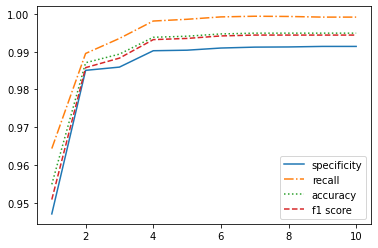

In [126]:
index = range(1,11)
plt.plot(index, specificity_list, label = "specificity", linestyle="-")
plt.plot(index, recall_list, label = "recall", linestyle="-.")
plt.plot(index, accuracy_list, label = "accuracy", linestyle=":")
plt.plot(index, f1_score_list, label = "f1 score", linestyle="--")
plt.legend()
plt.show()

### Best min_leaf_sample & Max features

In [130]:
from sklearn.metrics import recall_score
recall_list_joint = []
accuracy_list_joint = []
f1_score_list_joint = []
specificity_list_joint = []
no_leaves = [3, 5, 10, 15, 30, 50, 100]
no_features = [3, 5, 10, 13, 15, 20, 30, 40, 50]
for i in no_leaves:
    for j in no_features:
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = i, max_features = j, criterion = 'gini', oob_score = True, bootstrap = True, random_state = 30)
        clf.fit(dataset, Y_train)
        prediction = clf.predict(dataset)
        recall = recall_score(Y_train, prediction)
        accuracy = accuracy_score(Y_train, prediction)
        f1_val = f1_score(Y_train, prediction)
        recall_list.append(recall)
        recall_list_joint.append(recall)
        accuracy_list_joint.append(accuracy)
        f1_score_list_joint.append(f1_val)
        tn, fp, fn, tp = confusion_matrix(Y_train, prediction).ravel()
        specificity_list_joint.append(tn / (tn+fp))
        print(i,j)

3 3
3 5
3 10
3 15
3 20
3 30
3 40
3 50
5 3
5 5
5 10
5 15
5 20
5 30
5 40
5 50
10 3
10 5
10 10
10 15
10 20
10 30
10 40
10 50
15 3
15 5
15 10
15 15
15 20
15 30
15 40
15 50
30 3
30 5
30 10
30 15
30 20
30 30
30 40
30 50
50 3
50 5
50 10
50 15
50 20
50 30
50 40
50 50
100 3
100 5
100 10
100 15
100 20
100 30
100 40
100 50


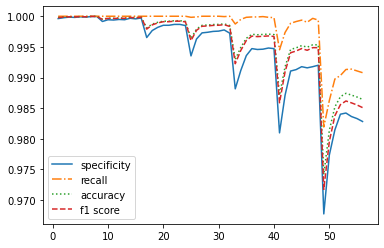

In [136]:
index = range(1,57)
plt.plot(index, specificity_list_joint, label = "specificity", linestyle="-")
plt.plot(index, recall_list_joint, label = "recall", linestyle="-.")
plt.plot(index, accuracy_list_joint, label = "accuracy", linestyle=":")
plt.plot(index, f1_score_list_joint, label = "f1 score", linestyle="--")
plt.legend()
plt.show()

### Final Model

In [94]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 50, max_features = 12, criterion = 'gini', oob_score = True, bootstrap = True, random_state = 30)
clf.fit(dataset, Y_train)
prediction = clf.predict(dataset)

In [134]:
y_pred = (clf.predict_proba(dataset_test)[:,1] >= 0.15).astype(bool) # set threshold as 0.3

In [148]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, prediction)

array([[20662,   361],
       [  160, 17220]], dtype=int64)

In [149]:
sum(prediction)

17581

In [150]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      7693
           1       0.28      0.89      0.43       726

    accuracy                           0.79      8419
   macro avg       0.63      0.84      0.65      8419
weighted avg       0.93      0.79      0.84      8419



In [117]:
prediction

array([[0.54933327, 0.45066673],
       [0.5502719 , 0.4497281 ],
       [0.54066986, 0.45933014],
       ...,
       [0.99192266, 0.00807734],
       [0.98789979, 0.01210021],
       [0.98820257, 0.01179743]])

In [253]:
indices = [i for i in range(len(Y_test)) if Y_test[i] != y_pred[i]]

In [254]:
indices

[1064,
 1100,
 1101,
 1104,
 1105,
 1108,
 1109,
 1130,
 1149,
 1153,
 1384,
 1385,
 1388,
 1389,
 1390,
 1396,
 1616,
 1617,
 1618,
 1619,
 1735,
 1738,
 1866,
 1867,
 1879,
 1883,
 1895,
 1897,
 1899,
 2028,
 2031,
 2032,
 2035,
 2048,
 2055,
 2979,
 2981,
 2982,
 2987,
 2988,
 2989,
 2990,
 2994,
 2995,
 2996,
 2997,
 2998,
 3002,
 3003,
 3004,
 3005,
 3028,
 3029,
 3030,
 3035,
 3036,
 3038,
 3039,
 3042,
 3043,
 3044,
 3045,
 3046,
 3048,
 3049,
 3050,
 3051,
 3052,
 3053,
 3054,
 3056,
 3057,
 3058,
 3059,
 3060,
 3061,
 3066,
 3067,
 3083,
 3084,
 3085,
 3091,
 3092,
 3093,
 3094,
 3099,
 3100,
 3101,
 3102,
 3104,
 3105,
 3106,
 3107,
 3108,
 3109,
 3110,
 3112,
 3113,
 3114,
 3115,
 3116,
 3117,
 3118,
 3122,
 3123,
 3124,
 3139,
 3140,
 3147,
 3148,
 3149,
 3150,
 3153,
 3154,
 3155,
 3156,
 3157,
 3158,
 3160,
 3161,
 3162,
 3163,
 3164,
 3165,
 3166,
 3168,
 3169,
 3170,
 3171,
 3172,
 3173,
 3177,
 3178,
 3179,
 3180,
 3195,
 3196,
 3201,
 3202,
 3203,
 3204,
 3205,
 3206,

In [84]:
print(clf.oob_score_)

0.9898314451505941


In [85]:
clf.oob_decision_function_

array([[2.18244867e-02, 9.78175513e-01],
       [2.15484056e-02, 9.78451594e-01],
       [1.27191596e-02, 9.87280840e-01],
       ...,
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [9.99925926e-01, 7.40740741e-05]])

### Cross-Validate

In [152]:
from sklearn.model_selection import cross_validate
scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(clf, dataset, Y_train, cv=5, scoring=scoring)

In [153]:
scores

{'fit_time': array([176.78036904, 160.78935862, 152.10221982, 196.30412436,
        152.607265  ]),
 'score_time': array([0.15782619, 0.14663959, 0.23038054, 0.17913103, 0.25830984]),
 'test_precision_macro': array([0.85756293, 0.96568442, 0.97982575, 0.79690531, 0.8627102 ]),
 'test_recall_macro': array([0.85904948, 0.95962044, 0.97918135, 0.65431985, 0.79214122])}

### ROC Curve

C:\Users\ellen\AppData\Local\R-MINI~1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


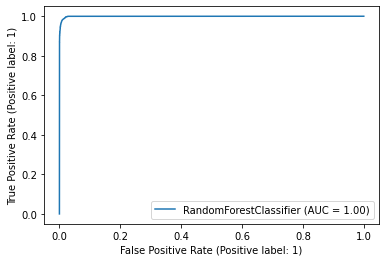

In [147]:
from sklearn import metrics
metrics.plot_roc_curve(clf, dataset, Y_train)

C:\Users\ellen\AppData\Local\R-MINI~1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


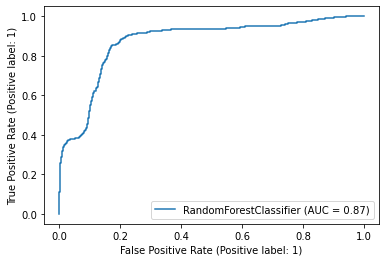

In [146]:
metrics.plot_roc_curve(clf, dataset_test, Y_test)

### Test Model

In [90]:
y_pred = (clf.oob_decision_function_[:,1] >= 0.50).astype(bool)

In [91]:
y_pred

array([ True,  True,  True, ..., False, False, False])

In [89]:
[i[1] for i in clf.oob_decision_function_]

[0.9781755132649872,
 0.9784515944386843,
 0.9872808403629114,
 0.9866300181977264,
 0.9881191389387725,
 0.9853903808271057,
 0.992294754141453,
 0.9925673016483169,
 0.9719751911082322,
 0.9760746493268987,
 0.9649806695108846,
 0.9737303313555713,
 0.9844829628318975,
 0.9873561335520928,
 0.9860410557253274,
 0.9567314323454329,
 0.9888177067294396,
 0.984011306081596,
 0.9891287801376568,
 0.9844751487965011,
 0.9918693586992147,
 0.9857909759921111,
 0.9859342867702957,
 0.993466452640669,
 0.9971073930145541,
 0.9963318608811768,
 0.9965295470523766,
 0.9966924929749811,
 0.9963188957128053,
 0.9962051432409494,
 0.9964453547057324,
 0.9972444865731717,
 0.9950189904150706,
 0.9955842111667768,
 0.9953420924403962,
 0.9955418236605794,
 0.9983660344943953,
 0.9945128069850596,
 0.9955778695365085,
 0.99759182551275,
 0.9973847766634534,
 0.9977217016260819,
 0.9980375614968652,
 0.9976400967986181,
 0.9340964806177354,
 0.9203465260171547,
 0.8600874325605643,
 0.861049718238877

In [92]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, y_pred)

array([[11032,   111],
       [   73,  6879]], dtype=int64)

In [86]:
pred = np.argmax(clf.oob_decision_function_,axis=1)

In [87]:
pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [99]:
prediction_test = clf.predict(dataset_test)

In [100]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, prediction_test)

array([[7552,  141],
       [ 457,  269]], dtype=int64)

In [101]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7693
           1       0.66      0.37      0.47       726

    accuracy                           0.93      8419
   macro avg       0.80      0.68      0.72      8419
weighted avg       0.92      0.93      0.92      8419



In [136]:
y_pred_test = (clf.predict_proba(dataset_test)[:,1] >= 0.).astype(bool) # set threshold as 0.3

In [137]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, y_pred_test)

array([[9441, 1502],
       [  13,  713]], dtype=int64)

In [138]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93     10943
           1       0.32      0.98      0.48       726

    accuracy                           0.87     11669
   macro avg       0.66      0.92      0.71     11669
weighted avg       0.96      0.87      0.90     11669



### Feature Importance

In [38]:
names

Index(['min_T1', 'med_T1', 'mid_T1', 'mid_small_ratio_T1', 'mid_med_ratio_T1',
       'mid_large_ratio_T1', 'mid_small_ratio_T1_inc', 'mid_med_ratio_T1_inc',
       'mid_large_ratio_T1_inc', 'mean_T1', 'max_T1', 'min_FLAIR', 'mid_FLAIR',
       'mean_FLAIR', 'mid_small_ratio_FLAIR', 'mid_med_ratio_FLAIR',
       'mid_large_ratio_FLAIR', 'mid_small_ratio_FLAIR_inc',
       'mid_med_ratio_FLAIR_inc', 'mid_large_ratio_FLAIR_inc', 'med_FLAIR',
       'max_FLAIR', 'density_diff', 'sum_soft_tiss_binary',
       'sum_percent_soft_tiss', 'min_st', 'med_st', 'mid_st',
       'mid_small_ratio_st', 'mid_med_ratio_st', 'mid_large_ratio_st',
       'mid_small_ratio_st_inc', 'mid_med_ratio_st_inc',
       'mid_large_ratio_st_inc', 'mean_st', 'max_st', 'min_th_T1', 'med_th_T1',
       'mid_th_T1', 'mid_small_ratio_th_T1', 'mid_med_ratio_th_T1',
       'mid_large_ratio_th_T1', 'mid_small_ratio_th_T1_inc',
       'mid_med_ratio_th_T1_inc', 'mid_large_ratio_th_T1_inc', 'mean_th_T1',
       'max_th_T1', 

<AxesSubplot:>

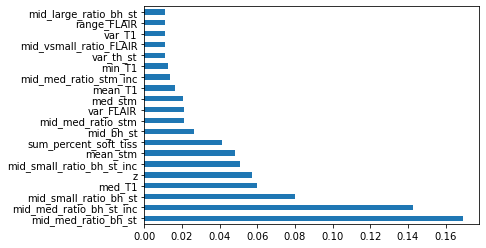

In [135]:
feat_importances = pd.Series(clf.feature_importances_, index=names)
feat_importances.nlargest(20).plot(kind='barh')

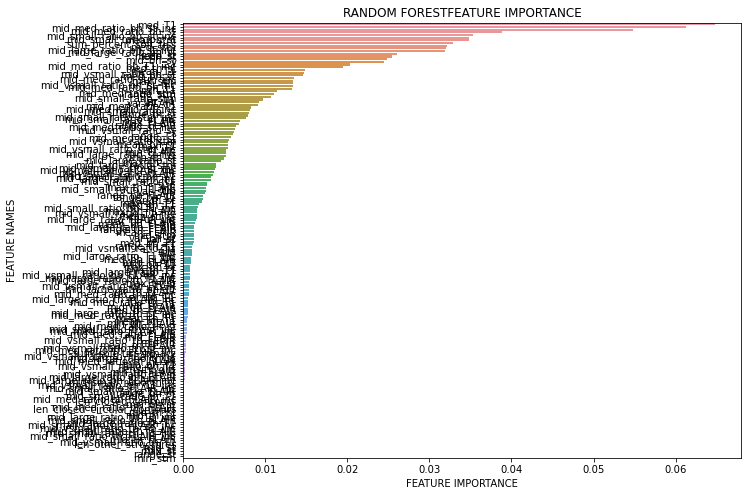

In [77]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
plot_feature_importance(clf.feature_importances_,names,'RANDOM FOREST')

### Thresholding

In [ ]:
from sklearn import metrics
metrics.plot_roc_curve(clf, X_train, y_train) 
plt.show

### Visualisations

In [ ]:
x,y,z = lacune_binary_roty.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red', s= 10)
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.set_zlim(-0, -20)

In [ ]:
lacune_binary_roty = np.rot90(Y_train_segment[0], axes=(1,2))

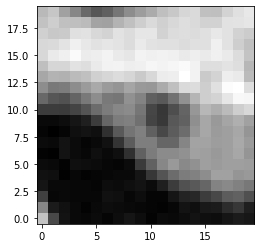

In [383]:
img = X_train[1400][4][:, 10, :]*255
input_image = img.copy()
input_image = input_image.astype('uint8')
plt.imshow(input_image, cmap="gray", origin="lower")
plt.show()

In [384]:
input_image
stacked_img = np.stack((input_image,)*3, axis=-1)

In [385]:
input_image = cv2.cvtColor(stacked_img, cv2.COLOR_BGR2GRAY)
input_image = cv2.medianBlur(input_image, 3)
ret, thresh = cv2.threshold(input_image, 90, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

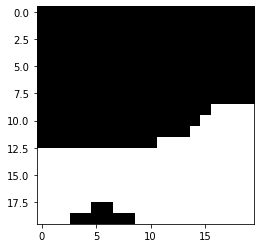

In [386]:
plt.imshow(thresh, cmap = "gray")
plt.show()

In [387]:
closed_contours = []
i = 0
#print(len(contours))
for cnt in contours:
    area = cv2.contourArea(cnt)
    print(area)
    if (cv2.isContourConvex(cnt) == True) & (area > 3) & (area < 175):
        print(area + 'hello')
        closed_contours.append(cnt)
    else:
        i+=1
contours_cirles = []
# check if contour is of circular shape
for con in closed_contours:
    perimeter = cv2.arcLength(con, True)
    area = cv2.contourArea(con)
    if (perimeter == 0):
        continue
    circularity = 4*math.pi*(area/(perimeter*perimeter))
    print(circularity)
    if 0.7 < circularity < 1.2:
        contours_cirles.append(con)
len_closed_contours.append(len(closed_contours))
len_closed_circular_contours.append(len(contours_cirles))
len_other_structures.append(i)
print(len(closed_contours))

128.0
0


In [388]:
import math
contours_cirles = []
# check if contour is of circular shape
for con in contours:
    perimeter = cv2.arcLength(con, True)
    area = cv2.contourArea(con)
    print(perimeter)
    print(area)
    if perimeter == 0:
        continue
    circularity = 4*math.pi*(area/(perimeter*perimeter))
    print(circularity)
    if 0.7 < circularity < 1.2:
        contours_cirles.append(con)

57.3137081861496
128.0
0.4896692332257581


In [208]:
closed_contours = []

i = 0
for cnt in contours:
   if cv2.isContourConvex(cnt) == True:
      closed_contours.append(cnt)
   else:
      i+=1

In [209]:
len(closed_contours)

1

In [210]:
i

1

In [175]:
closed_contours = []
i = 0
for cnt in contours:
   if cv2.isContourConvex(cnt) == True:
      closed_contours.append(cnt)
   else:
      i+=1
contours_cirles = []
# check if contour is of circular shape
for con in closed_contours:
    perimeter = cv2.arcLength(con, True)
    print(perimeter)
    area = cv2.contourArea(con)
    print(area)
    if (perimeter == 0) | (area < 5) | (area > 175):
        continue
    circularity = 4*math.pi*(area/(perimeter*perimeter))
    print(circularity)
    if 0.7 < circularity < 1.2:
        contours_cirles.append(con)
print(len(contours_cirles))
print(contours_cirles[0])

18.727921724319458
24.5
0.8778024272101497
1
[[[ 8  9]]

 [[11  9]]

 [[13 11]]

 [[10 14]]

 [[ 8 14]]

 [[ 6 12]]

 [[ 6 11]]]


In [ ]:
perimeter = cv2.arcLength(closed_contours[1],True)
perimeter

In [ ]:
area = cv2.contourArea(closed_contours[1], True)
area

In [ ]:
import math
contours_cirles = []
# check if contour is of circular shape
for con in closed_contours:
    print(con)
    perimeter = cv2.arcLength(con, True)
    area = cv2.contourArea(con)
    if perimeter == 0:
        break
    circularity = 4*math.pi*(area/(perimeter*perimeter))
    print(circularity)
    if 0.7 < circularity < 1.2:
        contours_cirles.append(con)

In [ ]:
cnt = contours_cirles[0]
im = cv2.drawContours(input_image, [cnt], 0, (0,255,0), 1)
plt.imshow(im, cmap = "gray")
plt.show()

In [ ]:
import cv2

image = cv2.imread('1.jpg')
blur = cv2.medianBlur(image, 9)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 110 ,255, cv2.THRESH_BINARY_INV)[1]

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

min_area = 5000
for c in cnts:
    area = cv2.contourArea(c)
    if area > min_area:
        cv2.drawContours(image,[c], 0, (36,255,12), 2)

cv2.imshow('thresh', thresh)
cv2.imshow('image', image)
cv2.waitKey(0)

### Top hat

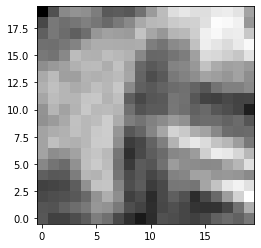

In [255]:
filterSize =(16, 16)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                   filterSize)
# Reading the image named 'input.jpg'
input_image = X_train[7223][4][:, 10, :]
  
# Applying the Black-Hat operation
tophat_img = cv2.morphologyEx(input_image, 
                              cv2.MORPH_BLACKHAT,
                              kernel)

plt.imshow(tophat_img, cmap="gray", origin="lower")
plt.show()

In [256]:
tophat_img_T1 = cv2.morphologyEx(X_train[4944][4], cv2.MORPH_BLACKHAT,kernel)

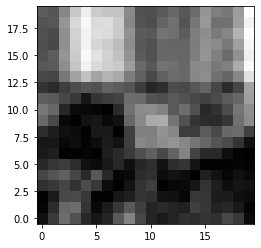

In [258]:
plt.imshow(tophat_img_T1[:, 9, :], cmap="gray", origin="lower")
plt.show()

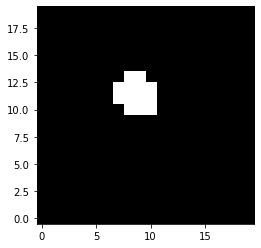

In [123]:
input_image = Y_train_segment[0][:, 10, :]
  
# Applying the Black-Hat operation
#tophat_img = cv2.morphologyEx(input_image, cv2.MORPH_TOPHAT, kernel)

plt.imshow(input_image, cmap="gray", origin="lower")
plt.show()

In [154]:
any(any(row for row in ((X_train[4823][5][:, 10, :])<50)))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [200]:
any(1 in sublist for sublist in (X_train[4816][5][:, 10, :]*255<40))

False

In [ ]:
### Testing
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 50, max_features = 12, criterion = 'gini', oob_score = True, bootstrap = True, random_state = 30)
clf.fit(dataset, Y_train)
prediction_test = clf.predict(dataset_test)